In [1]:
%pylab inline
import random
import numpy as np
from scipy.optimize import minimize


Populating the interactive namespace from numpy and matplotlib


In [139]:
###########
# In simulations below:
# G = num genes
# T = % target genes
# L = lambda* (non-null pvals follow exponential (lambda=lambda*))
###########

############### Simulation functions #################
# Simulate pvals for given T, Lambda*
# def SimulatePvals(G, T, L):
#     # Simulate log pvalues
#     pvals = []
#     for i in range(G):
#         if random.random() < T:
#             pvals.append(np.random.exponential(L))
#         else:
#             pvals.append(np.random.exponential(1))
#     return pvals

def SimulatePvals(G, T, L):
    # Simulate log pvalues
    pvals = []
    
    n_latent = np.random.binomial(n=G, p=T)
    pvals_latent = np.random.exponential(L, size=n_latent)
    pvals_non_latent = np.random.exponential(1, size=G-n_latent)
    pvals = np.concatenate((pvals_latent, pvals_non_latent))
    np.random.shuffle(pvals)
    return pvals
######################################################

############### Likelihood functions #################
def LogLikelihood(pvals, T, L):
    """
    Compute likelihood of log pvals, given T=% non-null, and L=lambda for non-null
    """
    loglik = 0
    for p in pvals:
        loglik += np.log(GetProb(p, T, L))
    return loglik

def ExpProb(p, L):
    """
    Helper function for likelihood
    Return pdf from exponential
    """
    return 1/L*np.exp(-p*1/L)
    
def GetProb(p, T, L):
    """
    Helper function for likelihood
    Compute probablity of p for a given T and L
    """
    return T*ExpProb(p, L) + (1-T)*ExpProb(p, 1)
######################################################

############### Plotting functions ###################
def QQPlot(pvals, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    null = np.random.exponential(1, size=G)
    ax.scatter(sorted(null), sorted(pvals))
    ax.plot([0, max(null)], [0, max(null)])
    ax.set_xlabel("Expected log p")
    ax.set_ylabel("Observed log p");
    if title is not None: ax.set_title(title)
    

def LikPlot(Tvals, LogLiks, T, title=None):
    """
    Plot T vs. log likelihood
    """
    maxLik = Tvals[LogLiks.index(max(LogLiks))]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(Tvals, LogLiks, color="black", label="LogLik")
    ax.axvline(x=T, color="black", linestyle="dashed", label="True T")
    ax.axvline(x=maxLik, color="red", linestyle="dashed", label="Max. Likelihood T")
    ax.set_xlabel("T (% non-null)")
    ax.set_ylabel("log lik")
    ax.legend()
    if title is not None: ax.set_title(title)
######################################################

# Stepwise method for finding BestT and BestL

In [140]:
# Could we even get both T and L if both are unknown?
# Idea, kind of like an EM algorithm: 
#  Guess L
#  Find best T holding L constant
#  Find best L holding T constant
#  Repeat until convergence
# Alternatively, we can just earch over L,T exhaustively

############### Optimization/EM functions ###################

# Naive functions to find best T, L by testing range of values
#def FindBestT(pvals, L):
#    Tvals = np.arange(0, 1, 0.01)
#    LogLiks = [LogLikelihood(pvals, t, L) for t in Tvals] # exhaustive search. could speed this up
#    maxLikT = Tvals[LogLiks.index(max(LogLiks))]
#    return maxLikT, max(LogLiks)

#def FindBestL(pvals, T):
#    Lvals = np.arange(1, 3, 0.1)
#    LogLiks = [LogLikelihood(pvals, T, l) for l in Lvals] # exhaustive search. could speed this up
#    maxLikL = Lvals[LogLiks.index(max(LogLiks))]
#    return maxLikL, max(LogLiks)

# Better functions to find best T, L by using scipy.optimize.minimize
def NegLogLikT(L, pvals):
    def likfunc(t):
        return -1*LogLikelihood(pvals, t, L)
    return likfunc

def NegLogLikL(T, pvals):
    def likfunc(l):
        return -1*LogLikelihood(pvals, T, l)
    return likfunc

def FindBestT(pvals, L, initialGuessT=0.0):
    res = minimize(NegLogLikT(L, pvals), np.array([initialGuessT]), bounds=[(0, 1)])
    maxLikT = res.x[0] # best T from the optimizer
    LogLik = LogLikelihood(pvals, maxLikT, L) # likelihood of the best T
    return maxLikT, LogLik

def FindBestL(pvals, T, initialGuessL=1.0):
    res = minimize(NegLogLikL(T, pvals), np.array([initialGuessL]), bounds=[(1, 5)])
    maxLikL = res.x[0] # best T from the optimizer
    LogLik = LogLikelihood(pvals, T, maxLikL) # likelihood of the best T
    return maxLikL, LogLik
                                    

def FindBestTL(pvals, epsilon=0.1, maxiter=50):
    # Guess L
    guessL = 2.5
    guessT, maxlik = FindBestT(pvals, guessL)
    iternum = 1
    while True:
        print("GuessL=%s GuessT=%s Lik=%s"%(guessL, guessT, maxlik))
        # Find best L, holding T constant
        guessL, newlik = FindBestL(pvals, guessT)
        # Find best T, holding L constant
        guessT, newlik = FindBestT(pvals, guessL)
        # If we've converged, we're done
        if abs(newlik-maxlik)<epsilon:
            break
        # Give up at some point
        if iternum >= maxiter:
            guessL = float("nan")
            guessT = float("nan")
            break
        maxlik = newlik
        iternum += 1
    return guessL, guessT
######################################################

## Modification to stepwise BestT and Best L to search with different initial guesses

FindBestTL seems to be sensitive to what we use for the initial guesses. 

\* Plot right below shows trying different initial guesses to find BestT and BestL

** See plots at end of notebook (commented with the parameters (initial guess) that I tried for them, seems unstable

Method still doesn't seem very robust

In [141]:
# Since FindBestTL seems sensitive to the initial guesses, 
# maybe we can try several initial guesses and use the TL with the best maximum likelihood across all guesses

from operator import itemgetter
def FindBestTL_mod(pvals, guess, epsilon=0.1, maxiter=20):
    # Guess L
    guessL = guess
    guessT, maxlik = FindBestT(pvals, guessL)
    iternum = 1
    while True:
        print("GuessL=%s GuessT=%s Lik=%s"%(guessL, guessT, maxlik))
        # Find best L, holding T constant
        guessL, newlik = FindBestL(pvals, guessT)
        # Find best T, holding L constant
        guessT, newlik = FindBestT(pvals, guessL)
        # If we've converged, we're done
        if abs(newlik-maxlik)<epsilon:
            break
        # Give up at some point
        if iternum >= maxiter:
            guessL = float("nan")
            guessT = float("nan")
            break
        maxlik = newlik
        iternum += 1
    return (guessL, guessT, newlik)

def TryDiffGuess(pvals, guesses):
    all_guesses = []
    for guess in guesses:
        test = FindBestTL_mod(pvals, guess)
        #print(test)
        all_guesses.append(test)
    print(all_guesses)
    best = max(all_guesses, key=itemgetter(2))
    print(best)
    return best[0], best[1]

GuessL=1.1 GuessT=0.0 Lik=-14890.058901281034
GuessL=1.5 GuessT=0.0 Lik=-14890.058901281034
GuessL=2.0 GuessT=0.0 Lik=-14890.058901281034
GuessL=2.5 GuessT=0.0 Lik=-14890.058901281034
[(1.0, 0.0, -14890.058901281034), (1.0, 0.0, -14890.058901281034), (1.0, 0.0, -14890.058901281034), (1.0, 0.0, -14890.058901281034)]
(1.0, 0.0, -14890.058901281034)
#########################
trueL=1.1; estL=1.0; trueT=0.01; estT=0.0
GuessL=1.1 GuessT=0.1278595489653844 Lik=-15199.44881982221
GuessL=1.5 GuessT=0.01823862716070165 Lik=-15199.906337598915
GuessL=2.0 GuessT=0.005238911896059599 Lik=-15200.263887679883
GuessL=1.7802103363090587 GuessT=0.008650948183337542 Lik=-15200.129384858652
GuessL=1.6245361688494147 GuessT=0.012829190395455835 Lik=-15200.01353011267
GuessL=2.5 GuessT=0.001906735428460561 Lik=-15200.473883848623
GuessL=2.0888916507673727 GuessT=0.004333265581424951 Lik=-15200.309998729232
GuessL=1.8398386861628175 GuessT=0.00751055838125715 Lik=-15200.169002886265
GuessL=1.6665130713402596

GuessL=1.702508181956733 GuessT=0.18546253487256087 Lik=-16862.012574393164
GuessL=1.6543313608895425 GuessT=0.2001316560346393 Lik=-16860.95529600625
GuessL=1.6175988832302335 GuessT=0.21275580239523292 Lik=-16860.256153442402
GuessL=1.5888790501373202 GuessT=0.22365027559409817 Lik=-16859.781244304486
GuessL=1.565938288570653 GuessT=0.23309465776690078 Lik=-16859.45086692287
GuessL=1.5472945903267574 GuessT=0.24131985145246806 Lik=-16859.216433346326
GuessL=1.5319486304180219 GuessT=0.24849199499629016 Lik=-16859.047516636005
GuessL=1.5191722542621298 GuessT=0.2547718250146926 Lik=-16858.924105393126
GuessL=2.5 GuessT=0.07534715492732821 Lik=-16889.262488203753
GuessL=2.153068524584061 GuessT=0.10520115001123599 Lik=-16876.44166241095
GuessL=1.956078733887164 GuessT=0.13144594049486272 Lik=-16869.454973701704
GuessL=1.8320657198161816 GuessT=0.15398426986858857 Lik=-16865.494852118565
GuessL=1.7481294962285567 GuessT=0.1732079864562457 Lik=-16863.142835473787
GuessL=1.688121103581134

GuessL=1.9768119147423484 GuessT=0.10777467678213318 Lik=-16432.984638016478
GuessL=2.025407751409287 GuessT=0.10227166787785245 Lik=-16432.552156647354
GuessL=2.0641017430444117 GuessT=0.0982263524290032 Lik=-16432.300559056926
GuessL=2.094412533622521 GuessT=0.09524752550690102 Lik=-16432.15641367876
GuessL=2.0 GuessT=0.10508581799150779 Lik=-16432.761374428243
GuessL=2.0439950554928026 GuessT=0.10029315274582655 Lik=-16432.4215028949
GuessL=2.0787178481854265 GuessT=0.0967699094243607 Lik=-16432.225458502315
GuessL=2.1056590510051154 GuessT=0.0941798271655671 Lik=-16432.114111640054
GuessL=2.5 GuessT=0.06653100041450001 Lik=-16433.47787258727
GuessL=2.406490683337923 GuessT=0.07173113581452735 Lik=-16432.75874224993
GuessL=2.343481537805798 GuessT=0.07563232326973686 Lik=-16432.3881152053
GuessL=2.299777123752035 GuessT=0.07855235476040794 Lik=-16432.19385872289
GuessL=2.2690446303768543 GuessT=0.08072170895667276 Lik=-16432.091434749902
[(nan, nan, -16432.237229324535), (2.11771903

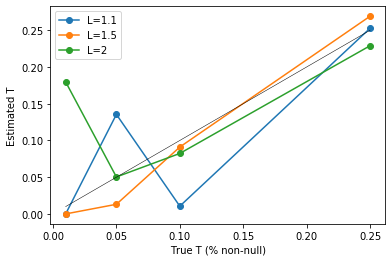

In [43]:
#Trying different initial guesses

######################################################
# Now, can we get it right if we don't know either T or L?
######################################################


Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
# trueTvals = [0.25]
for trueL in [1.1,  1.5, 2]:
# for trueL in [2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestL, bestT = TryDiffGuess(pvals, [1.1, 1.5, 2.0, 2.5])
        estTvals.append(bestT)
        print("#########################")
        title="trueL=%s; estL=%s; trueT=%s; estT=%s"%(trueL, bestL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()


# Using derived equation with t and L for mixture distribution 

-sum(log( (1-t)*e^(-p_i) + t*L* e^(-L*p_i) ))

Should find the minimum/bottom of the likelihood surface with the equation since the function is convex (to be able to use scipy optimize minimize function)
both parts of equation are concave, log should still keep the function concave. 
negative of function should make it convex

Optimizing T and L for derived equation is simple to do since there's only 2 variables

More direct than stepwise for bestT and bestL

In [142]:
import scipy.optimize, scipy.stats

def log_likelihood_neg(t, L, pvals):
    pvals = np.array(pvals)
    return -np.sum(np.log((1 - t) * np.exp(-pvals) + t * 1/L * np.exp(-1/L*pvals)))



In [455]:
pvals = SimulatePvals(15000, 1, 1.1)
get_bestTL(pvals)

(0.5960895308181684, 1.1526694785111171)

In [459]:
pvals = SimulatePvals(15000, 1, 1.1)
get_bestTL_guesses(pvals)

0.1
16302.905826438193 bestT, bestL: 1.0, 1.0907443915471997
0.25
16302.905826438193 bestT, bestL: 1.0, 1.0907443915471997
0.5
16302.905826438193 bestT, bestL: 1.0, 1.0907443915471997
0.75
16302.905826438193 bestT, bestL: 1.0, 1.0907443915471997
1
16302.905826438193 bestT, bestL: 1.0, 1.0907443915471997


(1.0, 1.0907443915471997)

In [531]:
pvals = SimulatePvals(15000, 0.1, 1.1)
get_bestTL_guesses(pvals)

(0.0468980223901717, 1.494203724008701)

In [513]:
scipy.optimize.minimize(lambda tL: log_likelihood_neg(*tL, pvals=pvals),
                            method='L-BFGS-B',
                            x0=(0.5, 1),
                            bounds=((10**(-5), 1),(10**(-5), None)))

      fun: 15895.731958228342
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0007276 , -0.00200089])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 18
   status: 0
  success: True
        x: array([0.23578929, 1.26226167])

In [528]:
def get_bestTL_guesses(pvals, init_guesses=None):
    if init_guesses is None:
        init_guesses = np.linspace(0, 1, 101)[1:-1]
    max_lklh = float('inf')
    for guess in init_guesses:
        # print(guess)
        results = scipy.optimize.minimize(lambda tL: log_likelihood_neg(*tL, pvals=pvals),
                                           # method='L-BFGS-B',
                                           x0=(guess, 1),
                                           bounds=((10**(-5), 1-10**(-5)),(10**(-5), None)))
        if results['fun'] < max_lklh:
            max_lklh = results['fun']
            x = results['x']
            bestT, bestL = x[0], x[1]
        # print(f'{max_lklh} bestT, bestL: {bestT}, {bestL}')
    return bestT, bestL

def get_bestTL(pvals):
    x = scipy.optimize.minimize(lambda tL: log_likelihood_neg(*tL, pvals=pvals),
                        method='L-BFGS-B',
                        x0=(0.5, 1),
                        bounds=((10**(-5), 1),(10**(-5), None)))['x']
    bestT, bestL = x[0], x[1]
    return bestT, bestL

def get_allTs(T, L, G, N):
    allTs = []
    for i in range(N):
        pvals = SimulatePvals(G, T, L)
#         bestT = get_bestTL(pvals)[0]
        bestT = get_bestTL_guesses(pvals)[0]
        allTs.append(bestT)
    allTs = np.array(allTs)
    return allTs

def get_medianT(T, L, G, N=500):
    allTs = get_allTs(T, L, G, N)
    medianT = np.median(allTs)
    return medianT

def get_medianTs(Ts, Ls, G, N=500):
    medianTs = {}
    for T in Ts:
        for L in Ls:
            print(T, L)
            medianT = get_medianT(T, L, G, N=N)
            medianTs[(T, L)] = medianT
    return medianTs

In [420]:
def get_bestTL_likelihood_ratio_test(pvals):
    null_lklh = log_likelihood_neg(0, 1, pvals)
    
    results = scipy.optimize.minimize(lambda tL: log_likelihood_neg(*tL, pvals=pvals),
                                           method='L-BFGS-B',
                                           x0=(0.5, 1),
                                           bounds=((10**(-5), 1),(10**(-5), None)))
    alt_lklh = results['fun']
    x = results['x']
    test_stat = -2*(-null_lklh + alt_lklh)
    pvalue = 1 - scipy.stats.chi2.cdf(test_stat, 1)
    if pvalue < 0.05:
        bestT = x[0]
    else:
        bestT = 0
    return bestT

def get_allTs_lklh(T, L, G, N):
    allTs = []
    for i in range(N):
        pvals = SimulatePvals(G, T, L)
        bestT = get_bestTL_likelihood_ratio_test(pvals)
        allTs.append(bestT)
    allTs = np.array(allTs)
    return allTs

def get_medianT_lklh(T, L, G, N=500):
    allTs = get_allTs(T, L, G, N)
    medianT = np.median(allTs)
    return medianT

def get_medianTs_lklh(Ts, Ls, G, N=500):
    medianTs = {}
    for T in Ts:
        for L in Ls:
            print(T, L)
            medianT = get_medianT(T, L, G, N=N)
            medianTs[(T, L)] = medianT
    return medianTs

In [256]:
def likelihood_ratio_test(pvals, trueT=None, trueL=None):
    assert (trueT is None) == (trueL is None)
    null_lklh = log_likelihood_neg(0, 1, pvals)
    if trueT is None:
        alt_lklh = scipy.optimize.minimize(lambda tL: log_likelihood_neg(*tL, pvals=pvals),
                                           method='L-BFGS-B',
                                           x0=(0.5, 1),
                                           bounds=((10**(-5), 1),(10**(-5), None)))['fun']
    else:
        alt_lklh = log_likelihood_neg(t=trueT, L=trueL, pvals=pvals)
    test_stat = -2*(-null_lklh + alt_lklh)
    
    pvalue = 1 - scipy.stats.chi2.cdf(test_stat, 1)
    return pvalue

In [259]:
# get pvalues of performing likelihood ratio test

def get_metapvals(T, L, G, N):
    meta_pvals = []
    for i in range(N):
        pvals = SimulatePvals(G, T, L)
        meta_pval = likelihood_ratio_test(pvals)
        meta_pvals.append(meta_pval)
    meta_pvals = np.array(meta_pvals)
    return meta_pvals

In [234]:
trueT, trueL = 0.01, 1.1
G = 15000

0.049

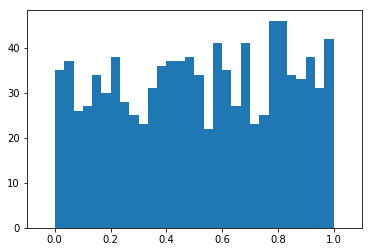

In [174]:
plt.hist(meta_pvals, bins=30)
plt.xlim(-0.1, 1.1)
alpha = 0.05
np.mean(meta_pvals < alpha)

In [260]:
def get_power(T, L, G, N=500):
    meta_pvals = get_metapvals(T, L, G, N)
    power = np.mean(meta_pvals <= alpha)
    return power

In [236]:
get_power(0.01, 1.1, 15000)

0.05

In [237]:
scipy.stats.kstest(meta_pvals, 'uniform')

KstestResult(statistic=0.03935277746956323, pvalue=0.08797014113968565)

In [261]:
def get_powers(Ts, Ls, G, N=500):
    powers = {}
    for T in Ts:
        for L in Ls:
            print(T, L)
            power = get_power(T, L, G, N=N)
            powers[(T, L)] = power
    return powers

In [263]:
Ts = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
Ls = [1, 1.1, 1.2, 1.5, 2]
# powers = get_powers(Ts=Ts, Ls=Ls, G=15000)
powers = get_powers(Ts=Ts, Ls=Ls, G=15000, N=1000)

0 1
0 1.1
0 1.2
0 1.5
0 2
0.01 1
0.01 1.1
0.01 1.2
0.01 1.5
0.01 2
0.02 1
0.02 1.1
0.02 1.2
0.02 1.5
0.02 2
0.05 1
0.05 1.1
0.05 1.2
0.05 1.5
0.05 2


/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


0.1 1
0.1 1.1
0.1 1.2
0.1 1.5
0.1 2
0.2 1
0.2 1.1
0.2 1.2
0.2 1.5
0.2 2


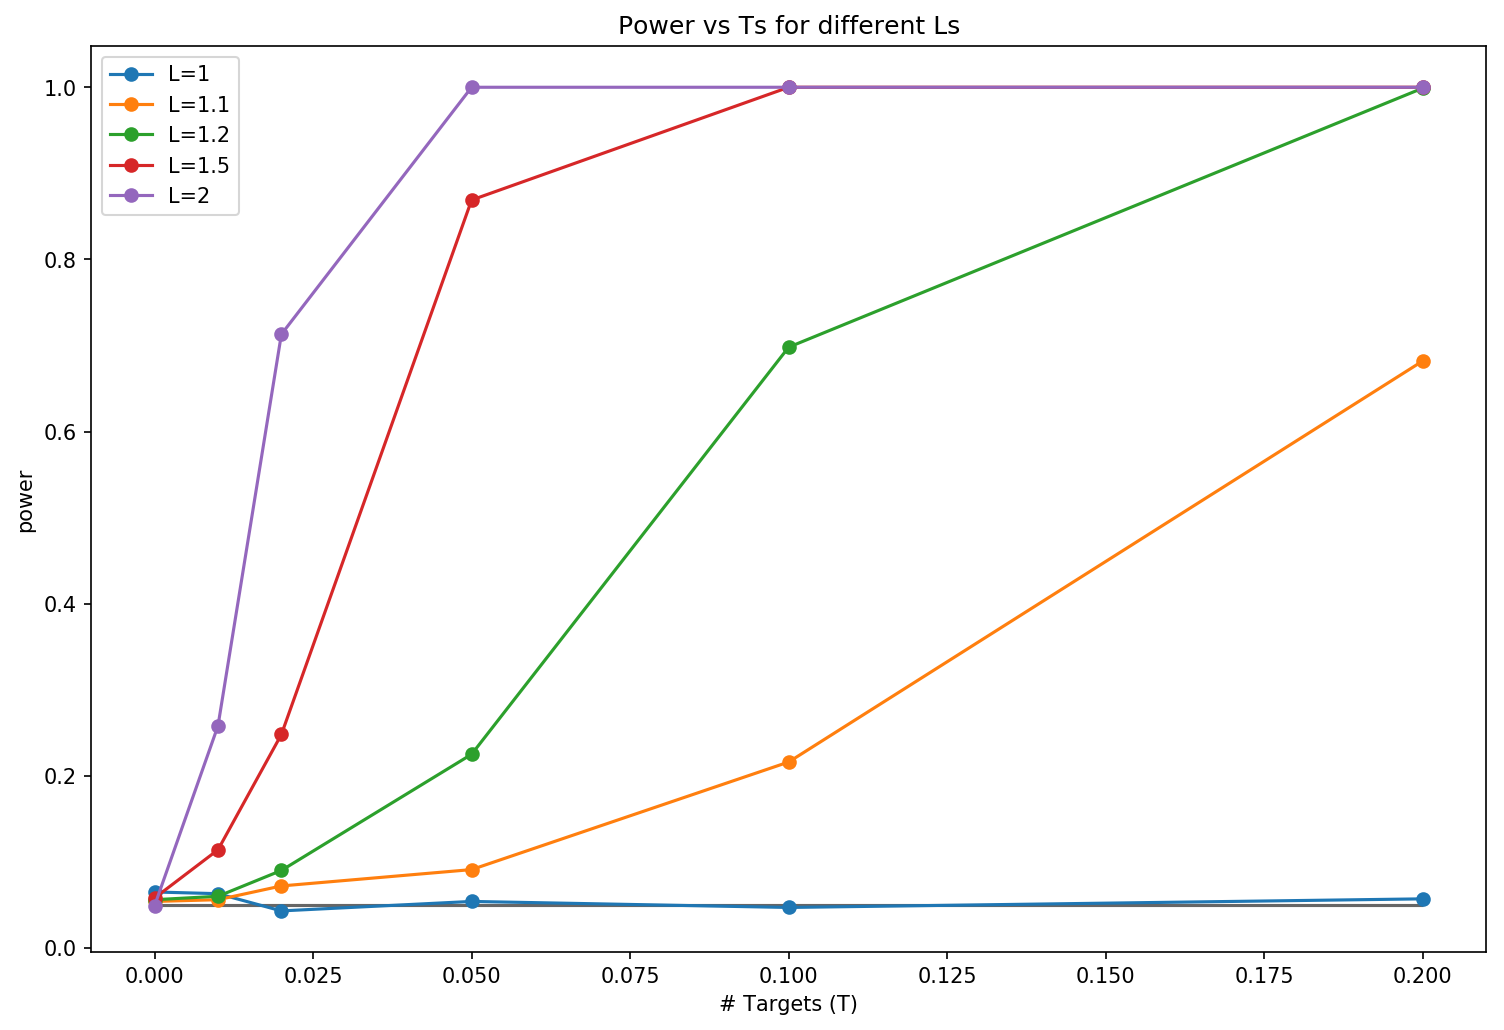

In [265]:
plt.figure(figsize=(12, 8), dpi=150)
for L in Ls:
    powers_L = [powers[(T, L)] for T in Ts]
    plt.plot(Ts, powers_L, label="L=%s"%L, marker="o")
plt.xlabel("# Targets (T)")
plt.ylabel("power")
plt.title('Power vs Ts for different Ls')
plt.hlines(0.05, min(Ts), max(Ts), alpha=0.6)
# ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
plt.legend()

In [429]:
allT = []
test = [0.1]
allT.append(test)
nextest = [0.3]
allT.append(nextest)
nextest = [0.5]
allT.append(nextest)
np.array(allT).T

array([[0.1, 0.3, 0.5]])

In [425]:
Ts = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Ls = [1, 1.1, 1.2, 1.5, 2]
medianT = get_medianTs(Ts=Ts, Ls=Ls, G=15000, N=100)

0 1
0 1.1
0 1.2
0 1.5
0 2
0.01 1
0.01 1.1
0.01 1.2
0.01 1.5
0.01 2
0.02 1
0.02 1.1
0.02 1.2
0.02 1.5
0.02 2
0.05 1
0.05 1.1
0.05 1.2
0.05 1.5
0.05 2
0.1 1
0.1 1.1
0.1 1.2
0.1 1.5
0.1 2
0.2 1
0.2 1.1
0.2 1.2
0.2 1.5
0.2 2
0.3 1
0.3 1.1
0.3 1.2
0.3 1.5
0.3 2
0.4 1
0.4 1.1
0.4 1.2
0.4 1.5
0.4 2
0.5 1
0.5 1.1
0.5 1.2
0.5 1.5
0.5 2
0.6 1
0.6 1.1
0.6 1.2
0.6 1.5
0.6 2
0.7 1
0.7 1.1
0.7 1.2
0.7 1.5
0.7 2
0.8 1
0.8 1.1
0.8 1.2
0.8 1.5
0.8 2
0.9 1
0.9 1.1
0.9 1.2
0.9 1.5
0.9 2
1.0 1
1.0 1.1
1.0 1.2
1.0 1.5
1.0 2


In [415]:
medianT

{(0, 1): 0.5000011347621731,
 (0, 1.1): 0.49999833632389024,
 (0, 1.2): 0.4999982020903331,
 (0, 1.5): 0.5000001999475976,
 (0, 2): 0.500000622611827,
 (0.01, 1): 0.49999603826333805,
 (0.01, 1.1): 0.49999955784676064,
 (0.01, 1.2): 0.4999985732114228,
 (0.01, 1.5): 0.49998914920991605,
 (0.01, 2): 0.49984933461004283,
 (0.02, 1): 0.5000000169232062,
 (0.02, 1.1): 0.5000003748484338,
 (0.02, 1.2): 0.49997240348454003,
 (0.02, 1.5): 0.49987251517152986,
 (0.02, 2): 0.04256579424591365,
 (0.05, 1): 0.5000007100343926,
 (0.05, 1.1): 0.49997614451112216,
 (0.05, 1.2): 0.4999020963598303,
 (0.05, 1.5): 0.07876678660240413,
 (0.05, 2): 0.05148114466467134,
 (0.1, 1): 0.499999639017181,
 (0.1, 1.1): 0.4998994917640056,
 (0.1, 1.2): 0.4995041221603158,
 (0.1, 1.5): 0.10244878473084974,
 (0.1, 2): 0.10327701830364383,
 (0.2, 1): 0.4999999392821898,
 (0.2, 1.1): 0.4997714008548885,
 (0.2, 1.2): 0.14878452635999362,
 (0.2, 1.5): 0.20759474591492838,
 (0.2, 2): 0.19936699631135057}

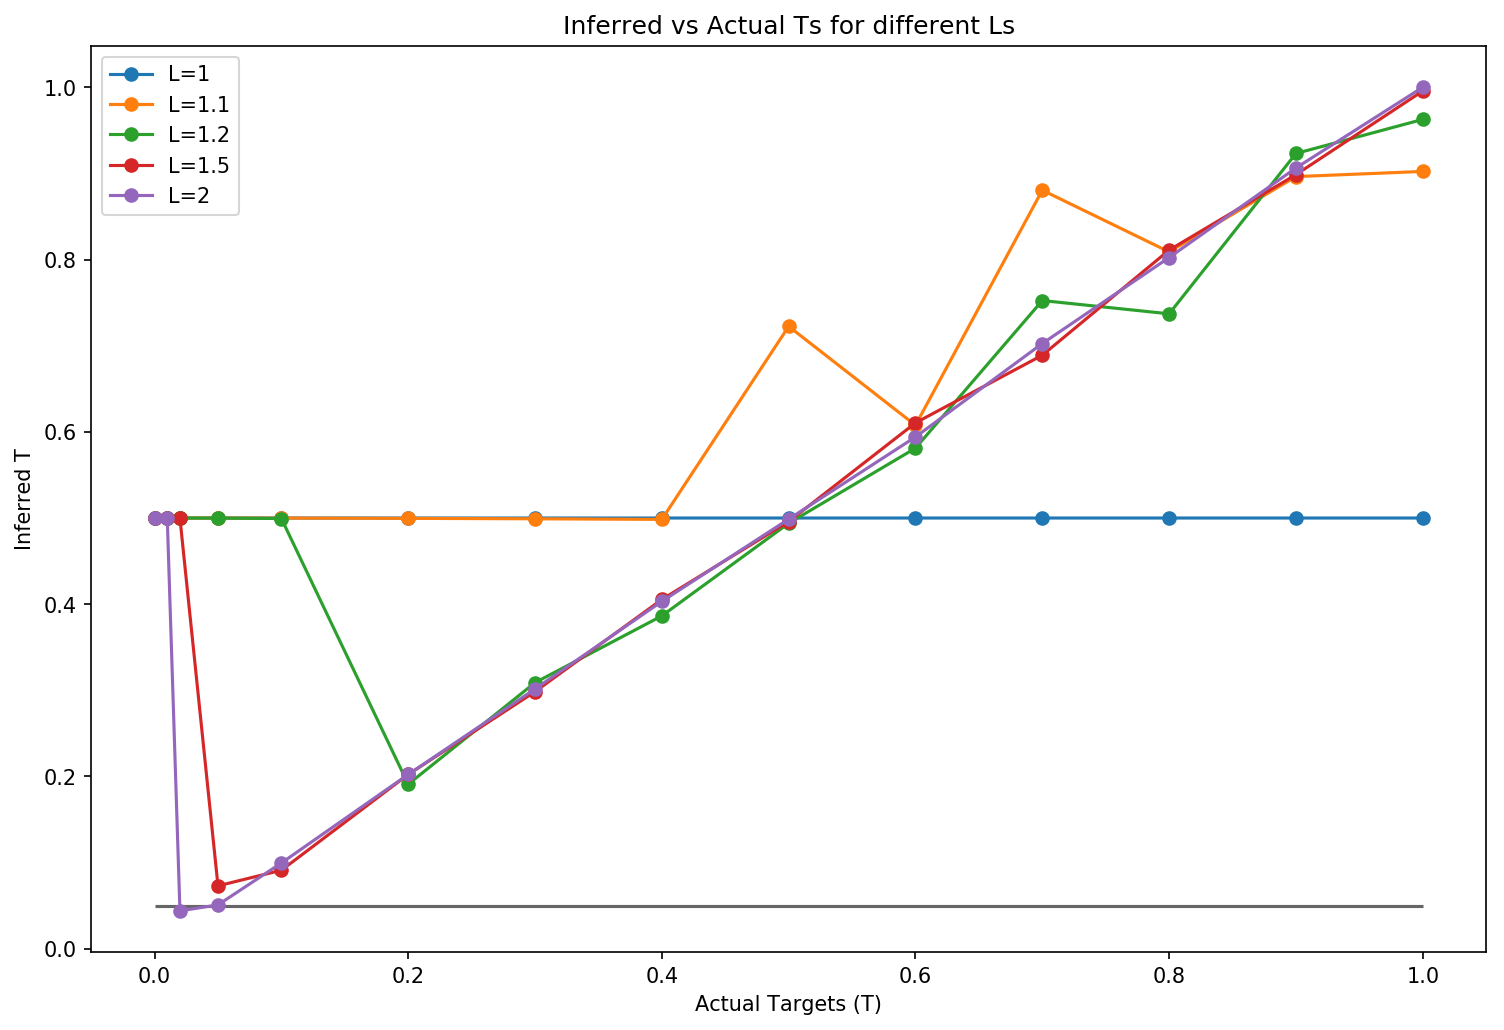

In [426]:
plt.figure(figsize=(12, 8), dpi=150)
Ls = [1, 1.1, 1.2, 1.5, 2]

for L in Ls:
    medT = [medianT[(T, L)] for T in Ts]
    plt.plot(Ts, medT, label="L=%s"%L, marker="o")
plt.xlabel("Actual Targets (T)")
plt.ylabel("Inferred T")
plt.title('Inferred vs Actual Ts for different Ls')
plt.hlines(0.05, min(Ts), max(Ts), alpha=0.6)
# ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
plt.legend()

In [422]:
Ts = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
Ls = [1, 1.1, 1.2, 1.5, 2]
medianT_lklh = get_medianTs_lklh(Ts=Ts, Ls=Ls, G=15000, N=100)

0 1
0 1.1
0 1.2
0 1.5
0 2
0.01 1
0.01 1.1
0.01 1.2
0.01 1.5
0.01 2
0.02 1
0.02 1.1
0.02 1.2
0.02 1.5
0.02 2
0.05 1
0.05 1.1
0.05 1.2
0.05 1.5
0.05 2
0.1 1
0.1 1.1
0.1 1.2
0.1 1.5
0.1 2
0.2 1
0.2 1.1
0.2 1.2
0.2 1.5
0.2 2


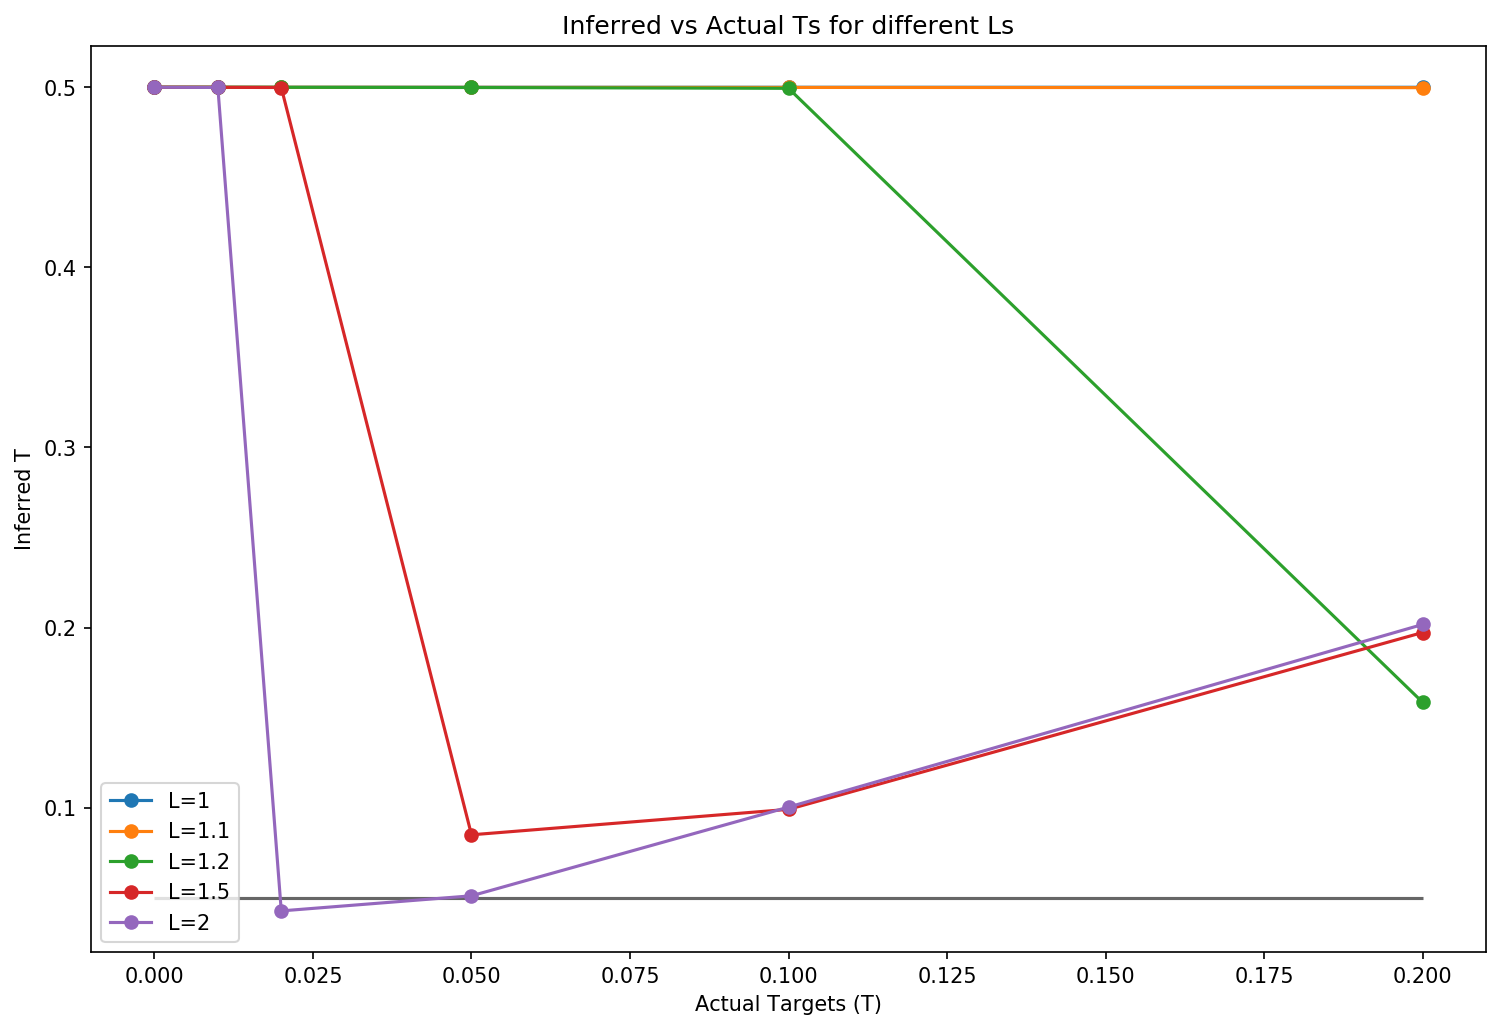

In [423]:
plt.figure(figsize=(12, 8), dpi=150)
Ls = [1, 1.1, 1.2, 1.5, 2]

for L in Ls:
    medT = [medianT_lklh[(T, L)] for T in Ts]
    plt.plot(Ts, medT, label="L=%s"%L, marker="o")
plt.xlabel("Actual Targets (T)")
plt.ylabel("Inferred T")
plt.title('Inferred vs Actual Ts for different Ls')
plt.hlines(0.05, min(Ts), max(Ts), alpha=0.6)
# ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
plt.legend()

 ## Infer T from actual simulated expression and genotype data

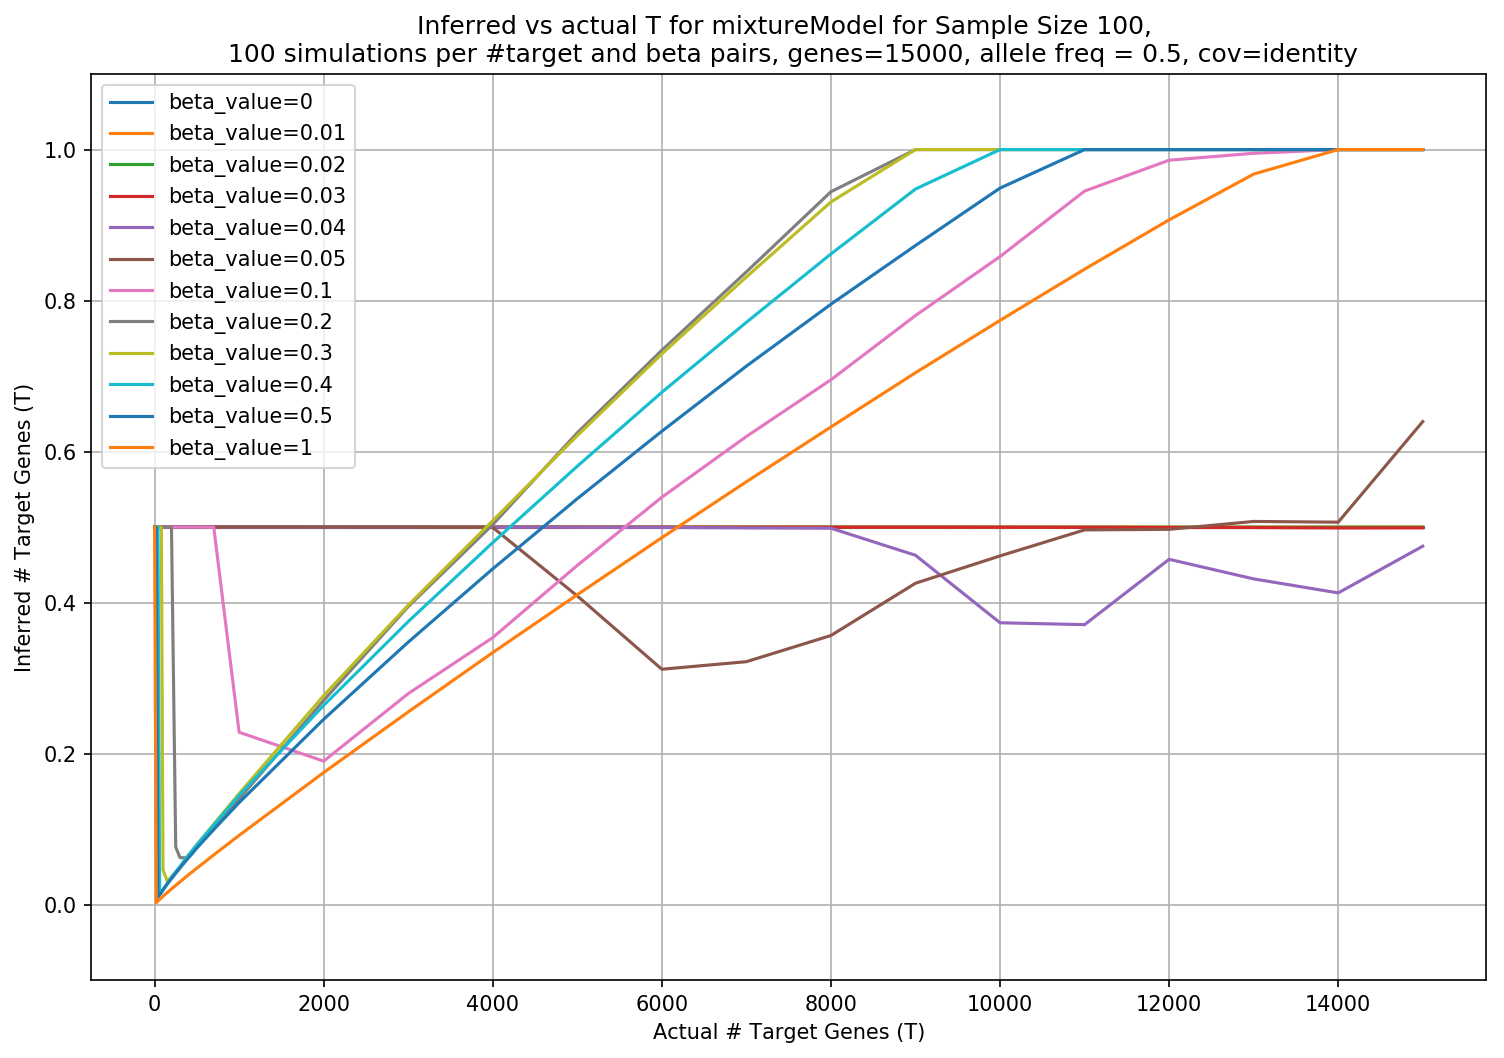

In [441]:
def plot_Ts(targets, beta_values, fname, label_name):
    inferredTs = []
    for beta in beta_values:
        for tar in targets:   
            value = str(beta).replace(".","")
            path = f'/gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_{tar}/Beta_{value}/{fname}'
            infer_targets = np.loadtxt(path)
            medT = np.median(infer_targets)
            inferredTs.append(medT)
#         print(len(inferredTs))
#         print(len(targets))
        plt.plot(targets, inferredTs, label=f'{label_name}={beta}')
        inferredTs = []


            
plt.figure(figsize=(12, 8), dpi=150)

# targets = [ 0, 20, 40, 60, 80, 100, 150, 200]
targets = [ 0, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
# targets = [ 0, 5, 10, 15, 20, 30, 40, 60, 80, 100]
#targets = [5, 10, 15, 30]

beta_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
# beta_values = [0.1]
plot_Ts(targets, beta_values, 'inferred_mixtureT', 'beta_value')
plt.xlabel('Actual # Target Genes (T)')
plt.ylabel('Inferred # Target Genes (T)')
plt.title('Inferred vs actual T for mixtureModel for Sample Size 100, \n 100 simulations per #target and beta pairs, genes=15000, allele freq = 0.5, cov=identity')
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()

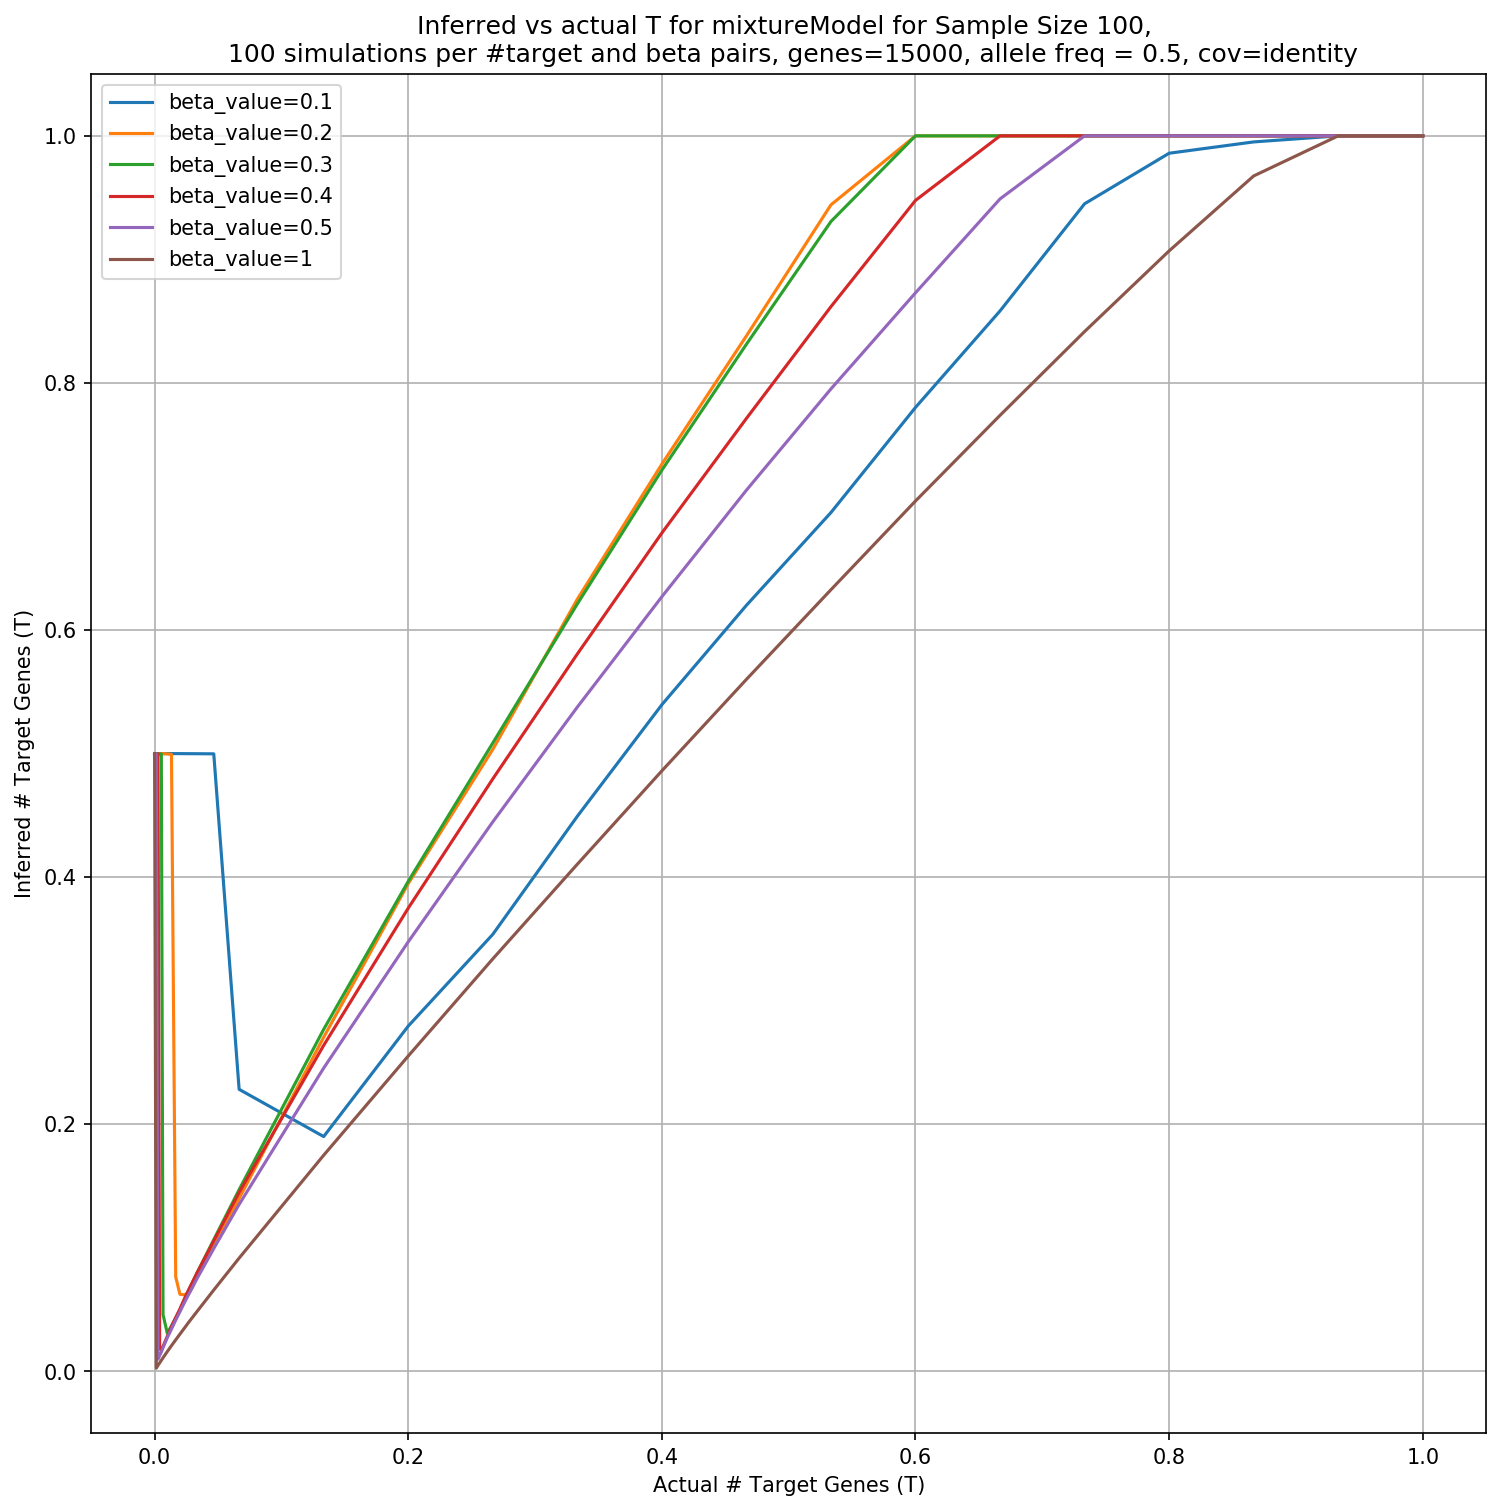

In [8]:
def plot_Ts(targets, beta_values, fname, label_name):
    inferredTs = []
    for beta in beta_values:
        for tar in targets:   
            value = str(beta).replace(".","")
            path = f'/gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_{tar}/Beta_{value}/{fname}'
            infer_targets = np.loadtxt(path)
            medT = np.median(infer_targets)
            inferredTs.append(medT)
#         print(len(inferredTs))
#         print(len(targets))
        plt.plot([tar/15000 for tar in targets], inferredTs, label=f'{label_name}={beta}')
        inferredTs = []


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42           
plt.figure(figsize=(12, 12), dpi=150)

# targets = [ 0, 20, 40, 60, 80, 100, 150, 200]
targets = [ 0, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
# targets = [ 0, 5, 10, 15, 20, 30, 40, 60, 80, 100]
#targets = [5, 10, 15, 30]

# beta_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
beta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 1]

# beta_values = [0.1]
plot_Ts(targets, beta_values, 'inferred_mixtureT', 'beta_value')
plt.xlabel('Actual # Target Genes (T)')
plt.ylabel('Inferred # Target Genes (T)')
plt.title('Inferred vs actual T for mixtureModel for Sample Size 100, \n 100 simulations per #target and beta pairs, genes=15000, allele freq = 0.5, cov=identity')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.savefig('/storage/cynthiawu/trans_eQTL/Scripts/Figures/xqtl_predictedvsActualT.pdf', dpi=300, bbox_inches = "tight")  


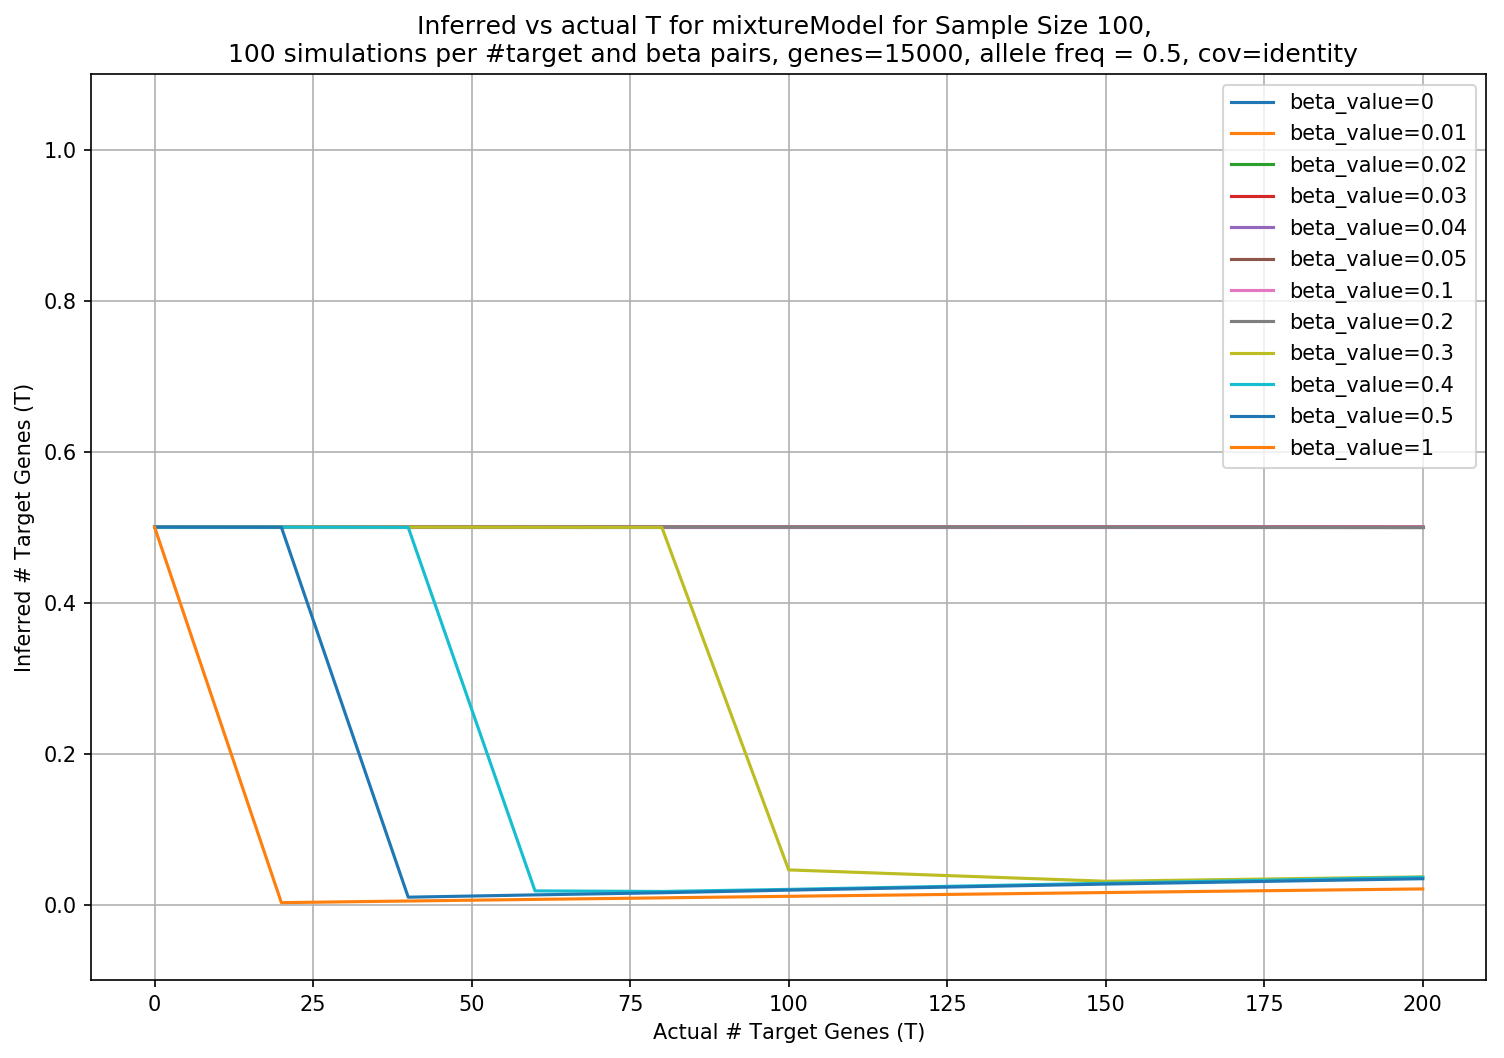

In [442]:
def plot_Ts(targets, beta_values, fname, label_name):
    inferredTs = []
    for beta in beta_values:
        for tar in targets:   
            value = str(beta).replace(".","")
            path = f'/gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_{tar}/Beta_{value}/{fname}'
            infer_targets = np.loadtxt(path)
            medT = np.median(infer_targets)
            inferredTs.append(medT)
#         print(len(inferredTs))
#         print(len(targets))
        plt.plot(targets, inferredTs, label=f'{label_name}={beta}')
        inferredTs = []


            
plt.figure(figsize=(12, 8), dpi=150)

targets = [ 0, 20, 40, 60, 80, 100, 150, 200]
# targets = [ 0, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
# targets = [ 0, 5, 10, 15, 20, 30, 40, 60, 80, 100]
#targets = [5, 10, 15, 30]

beta_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
# beta_values = [0.1]
plot_Ts(targets, beta_values, 'inferred_mixtureT', 'beta_value')
plt.xlabel('Actual # Target Genes (T)')
plt.ylabel('Inferred # Target Genes (T)')
plt.title('Inferred vs actual T for mixtureModel for Sample Size 100, \n 100 simulations per #target and beta pairs, genes=15000, allele freq = 0.5, cov=identity')
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()

 ## Infer T (modified) from actual simulated expression and genotype data

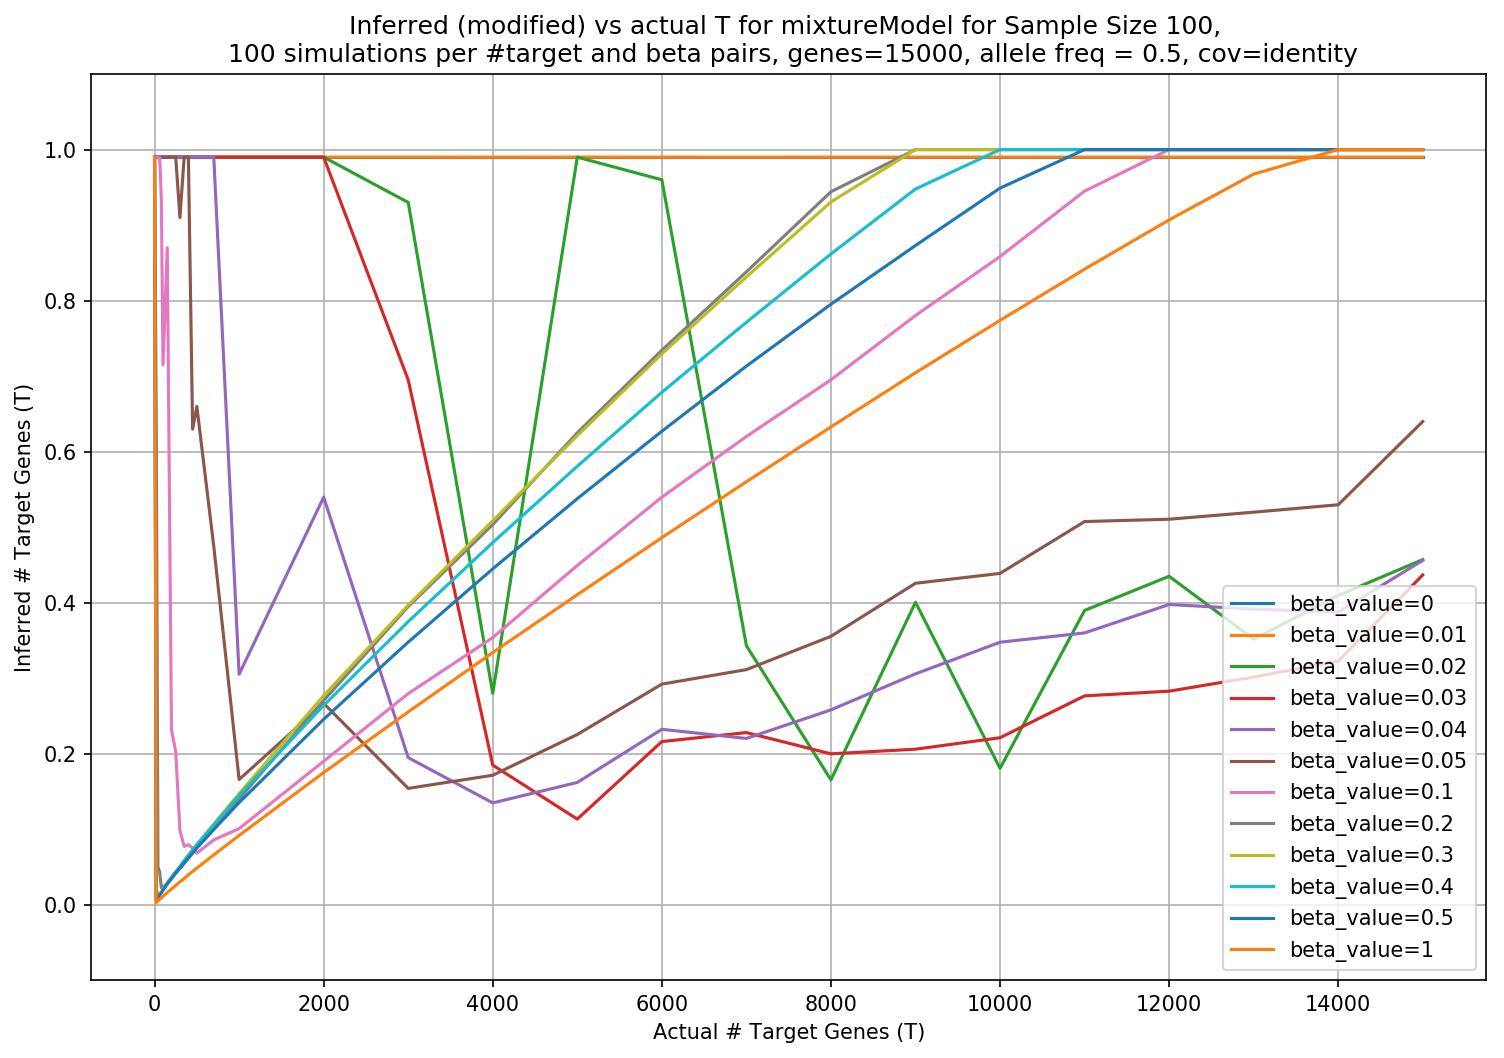

In [532]:
def plot_Ts(targets, beta_values, fname, label_name):
    inferredTs = []
    for beta in beta_values:
        for tar in targets:   
            value = str(beta).replace(".","")
            path = f'/gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_{tar}/Beta_{value}/{fname}'
            infer_targets = np.loadtxt(path)
            medT = np.median(infer_targets)
            inferredTs.append(medT)
#         print(len(inferredTs))
#         print(len(targets))
        plt.plot(targets, inferredTs, label=f'{label_name}={beta}')
        inferredTs = []


            
plt.figure(figsize=(12, 8), dpi=150)

# targets = [ 0, 20, 40, 60, 80, 100, 150, 200]
targets = [ 0, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
# targets = [ 0, 5, 10, 15, 20, 30, 40, 60, 80, 100]
#targets = [5, 10, 15, 30]

beta_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
# beta_values = [0.1]
plot_Ts(targets, beta_values, 'inferred_mixtureT_guesses', 'beta_value')
plt.xlabel('Actual # Target Genes (T)')
plt.ylabel('Inferred # Target Genes (T)')
plt.title('Inferred (modified) vs actual T for mixtureModel for Sample Size 100, \n 100 simulations per #target and beta pairs, genes=15000, allele freq = 0.5, cov=identity')
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()

## Compare Mixture Model with CPMA

In [347]:
# x is top x percent of genes to be used for cpma calculation

def cpmax(pvals, G, x):
    top_numgenes = math.ceil(x*G)
#     print(top_numgenes)
    pvals.sort()
    pvals = pvals[::-1]
#     pvals = -np.log(pvals)
    top_values = pvals[:top_numgenes]
    bordernum = top_values[-1]
    def log_likelihood_neg_cpma(x):
    #print(x)
        log_likelihood = top_numgenes*np.log(x) - \
                     x*np.sum(top_values) + \
                     (G-top_numgenes)*np.log(1-np.exp(-x*bordernum))
        return -log_likelihood
    if math.isclose(x, 1.0):
        max_likelihood = 1/np.mean(pvals)
    else:
        max_likelihood = scipy.optimize.minimize(log_likelihood_neg_cpma,
                                                 x0=1,
                                                 bounds=((10**(-10), None),))
        max_likelihood = max_likelihood.x[0]
#     print(max_likelihood)
    term1 = (1-max_likelihood)*np.sum(top_values)
    term2 = top_numgenes*np.log(max_likelihood)
    term3 = (G-top_numgenes)*np.log(1-math.exp(-max_likelihood*bordernum))
    term4 = -(G-top_numgenes)*np.log(1-math.exp(-bordernum))
#     print(term1, term2, term3, term4)
    cpmax_value = 2*(term1 + term2 + term3 + term4)
#     print(cpmax_value)
    pvalue = 1 - scipy.stats.chi2.cdf(cpmax_value, 1)
    return pvalue

In [356]:
# get pvalues of performing likelihood ratio test for mixture model and pvalues for cpmax 1.0

def get_metapvals_cpmapvals(T, L, G, N):
    meta_pvals = []
    cpma_pvals = []
    cpma_correctx_pvals = []
    for i in range(N):
        pvals = SimulatePvals(G, T, L)
        meta_pval = likelihood_ratio_test(pvals)
        meta_pvals.append(meta_pval)
        cpma_pval = cpmax(pvals, G, 1.0)
        cpma_pvals.append(cpma_pval)
        if T == 0:
            T = 0.00001
        cpma_correctx_pval = cpmax(pvals, G, T)
        cpma_correctx_pvals.append(cpma_correctx_pval)
    meta_pvals = np.array(meta_pvals)
    cpma_pvals = np.array(cpma_pvals)
    cpma_correctx_pvals = np.array(cpma_correctx_pvals)

    return meta_pvals, cpma_pvals, cpma_correctx_pvals

def get_power_both(T, L, G, N=500):
    meta_pvals, cpma_pvals, cpma_correctx_pvals = get_metapvals_cpmapvals(T, L, G, N)
    power_meta = np.mean(meta_pvals <= alpha)
    power_cpma = np.mean(cpma_pvals <= alpha)
    power_cpma_correctx = np.mean(cpma_correctx_pvals <= alpha)

    return power_meta, power_cpma, power_cpma_correctx

def get_powers_both(Ts, Ls, G, N=500):
    powers_meta = {}
    powers_cpma = {}
    powers_cpma_correctx = {}

    for T in Ts:
        for L in Ls:
            print(T, L)
            power_meta, power_cpma, power_cpma_correctx = get_power_both(T, L, G, N=N)
            powers_meta[(T, L)] = power_meta
            powers_cpma[(T, L)] = power_cpma
            powers_cpma_correctx[(T, L)] = power_cpma_correctx
    return powers_meta, powers_cpma, powers_cpma_correctx

from collections import defaultdict

def get_powers_both_iter(Ts, Ls, G, N=500, iterations=10):
    powers_meta = defaultdict(list)
    powers_cpma = defaultdict(list)
    powers_cpma_correctx = defaultdict(list)

    for i in range(iterations):
        for T in Ts:
            for L in Ls:
                print(T, L)
                power_meta, power_cpma, power_cpma_correctx = get_power_both(T, L, G, N=N)
                powers_meta[(T, L)].append(power_meta)
                powers_cpma[(T, L)].append(power_cpma)
                powers_cpma_correctx[(T, L)].append(power_cpma_correctx)
    return powers_meta, powers_cpma, powers_cpma_correctx

In [331]:
testval = 0.5
-np.log(testval)

0.6931471805599453

In [332]:
testval = 0.3
-np.log(testval)

1.2039728043259361

In [344]:
values = [4, 5, 1]
values = np.array(values)
values.sort()
values = values[::-1]

In [345]:
values

array([5, 4, 1])

In [309]:
(np.mean(pvals))

1.9934609590032473

In [305]:
1/-np.log(np.mean(pvals))

-1.4495436255748482

In [329]:
G=15000
T=0.1
L=2
pvals = SimulatePvals(G, T, L)
cpma_pval = cpmax(pvals, G, T)
cpma_pval

1500


0.0

In [350]:
Ts = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
Ls = [1, 1.1, 1.2, 1.5, 2, 5]
# powers = get_powers(Ts=Ts, Ls=Ls, G=15000)

powers_meta, powers_cpma, powers_cpma_correct = get_powers_both(Ts=Ts, Ls=Ls, G=15000, N=1000)

0 1
0 1.1
0 1.2
0 1.5
0 2
0 5
0.01 1
0.01 1.1
0.01 1.2


/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


0.01 1.5
0.01 2
0.01 5
0.02 1
0.02 1.1
0.02 1.2
0.02 1.5
0.02 2
0.02 5
0.05 1
0.05 1.1
0.05 1.2
0.05 1.5
0.05 2
0.05 5
0.1 1
0.1 1.1
0.1 1.2
0.1 1.5
0.1 2
0.1 5
0.2 1
0.2 1.1
0.2 1.2
0.2 1.5
0.2 2
0.2 5


In [370]:
Ts = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
Ls = [1, 1.1, 1.2, 1.5, 2, 5]
powers_meta_iter, powers_cpma_iter, powers_cpma_correct_iter = get_powers_both_iter(Ts=Ts, Ls=Ls, G=15000, N=1000)

0 1
0 1.1
0 1.2
0 1.5
0 2
0 5
0.01 1
0.01 1.1
0.01 1.2
0.01 1.5


/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


0.01 2
0.01 5
0.02 1
0.02 1.1
0.02 1.2
0.02 1.5
0.02 2
0.02 5
0.05 1
0.05 1.1
0.05 1.2
0.05 1.5
0.05 2
0.05 5
0.1 1
0.1 1.1
0.1 1.2
0.1 1.5
0.1 2
0.1 5
0.2 1
0.2 1.1
0.2 1.2
0.2 1.5
0.2 2
0.2 5
0 1
0 1.1
0 1.2
0 1.5
0 2
0 5
0.01 1
0.01 1.1
0.01 1.2
0.01 1.5
0.01 2
0.01 5
0.02 1
0.02 1.1
0.02 1.2
0.02 1.5
0.02 2
0.02 5
0.05 1
0.05 1.1
0.05 1.2
0.05 1.5
0.05 2
0.05 5
0.1 1
0.1 1.1
0.1 1.2
0.1 1.5
0.1 2
0.1 5
0.2 1
0.2 1.1
0.2 1.2
0.2 1.5
0.2 2
0.2 5
0 1
0 1.1
0 1.2
0 1.5
0 2
0 5
0.01 1
0.01 1.1
0.01 1.2
0.01 1.5
0.01 2
0.01 5
0.02 1
0.02 1.1
0.02 1.2
0.02 1.5
0.02 2
0.02 5
0.05 1
0.05 1.1
0.05 1.2
0.05 1.5
0.05 2
0.05 5
0.1 1
0.1 1.1
0.1 1.2
0.1 1.5
0.1 2
0.1 5
0.2 1
0.2 1.1
0.2 1.2
0.2 1.5
0.2 2
0.2 5
0 1
0 1.1
0 1.2
0 1.5
0 2
0 5
0.01 1
0.01 1.1
0.01 1.2
0.01 1.5
0.01 2
0.01 5
0.02 1
0.02 1.1
0.02 1.2
0.02 1.5
0.02 2
0.02 5
0.05 1
0.05 1.1
0.05 1.2
0.05 1.5
0.05 2
0.05 5
0.1 1
0.1 1.1
0.1 1.2
0.1 1.5
0.1 2
0.1 5
0.2 1
0.2 1.1
0.2 1.2
0.2 1.5
0.2 2
0.2 5
0 1
0 1.1
0 1.2
0 1.5
0 2
0 5
0.

In [375]:
means_L

[0.0505, 0.0534, 0.0541, 0.0533, 0.0523, 0.0524]

In [386]:
np.array(errors_L).T.shape

(2, 6)

In [391]:
powers_L

[[0.046, 0.045, 0.052, 0.051, 0.048, 0.058, 0.042, 0.043, 0.053, 0.054],
 [1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

In [390]:
errors_L

array([[0.04525, 1.     , 1.     , 1.     , 1.     , 1.     ],
       [0.05275, 1.     , 1.     , 1.     , 1.     , 1.     ]])

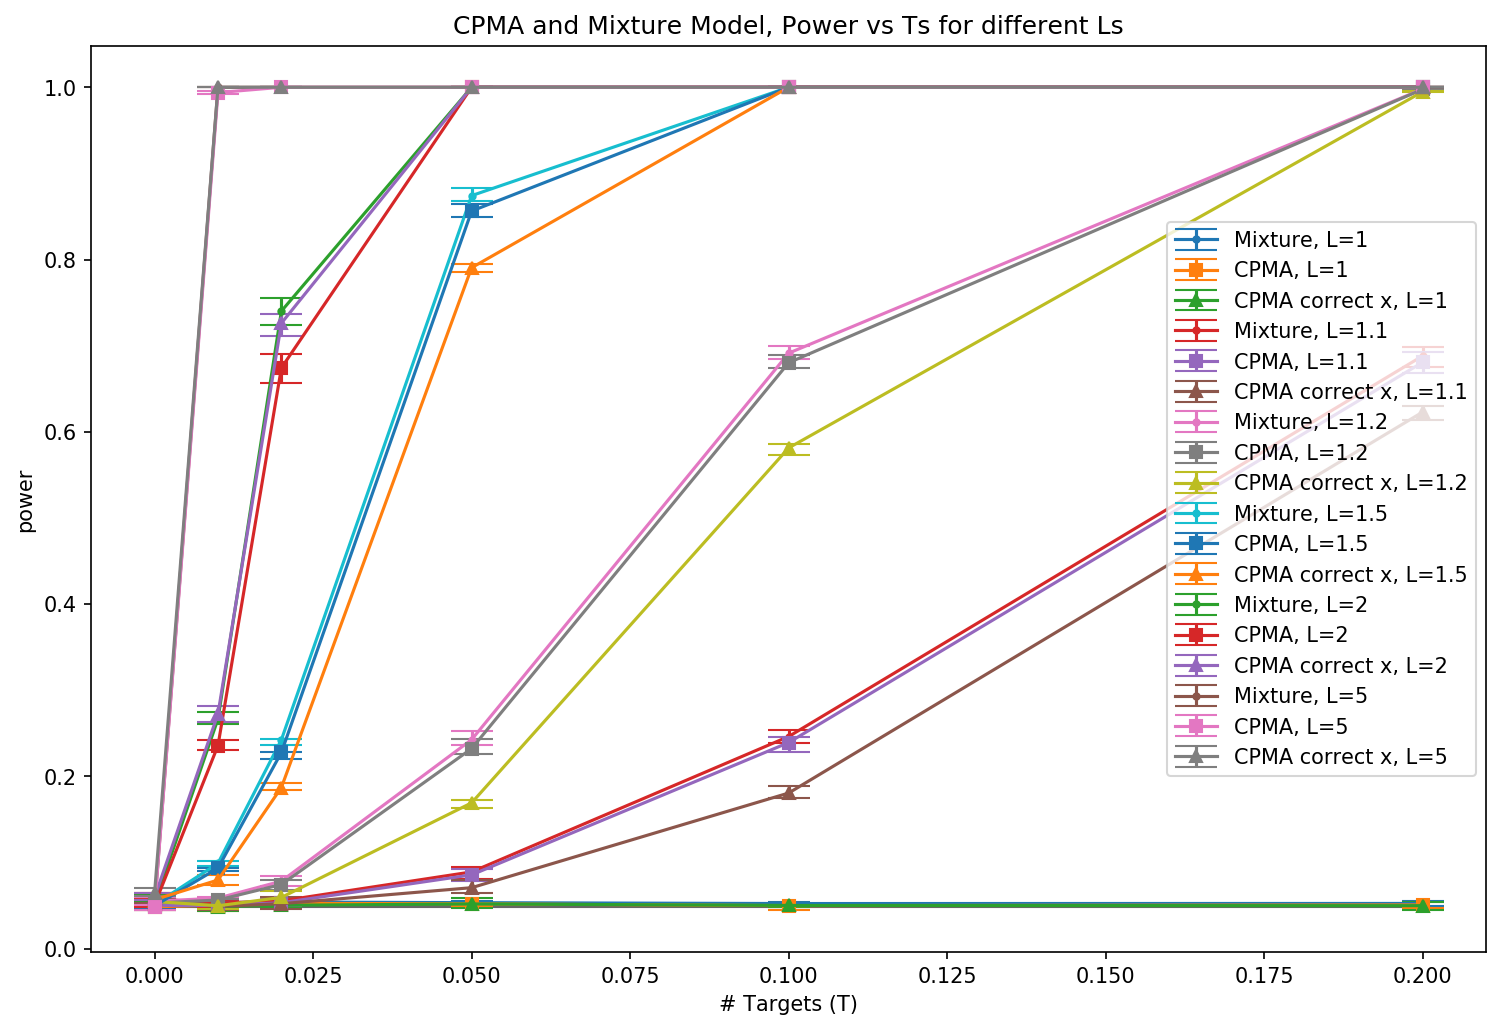

In [398]:
Ts = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
Ls = [1, 1.1, 1.2, 1.5, 2, 5]
plt.figure(figsize=(12, 8), dpi=150)
for L in Ls:
    powers_L = [powers_meta_iter[(T, L)] for T in Ts]
    means_L = [np.mean(x) for x in powers_L]
    errors_L = []
    for i in range(len(means_L)):
        errors_L.append([means_L[i] - np.percentile(powers_L[i], 25), np.percentile(powers_L[i], 75) - means_L[i]])
    errors_L = np.array(errors_L).T
#     errors_L = np.array([[np.percentile(x, 25), np.percentile(x, 75)] for x in powers_L]).T
    plt.errorbar(Ts, means_L, yerr=errors_L, label="Mixture, L=%s"%L, marker=".", capsize=10)
    
    powers_L = [powers_cpma_iter[(T, L)] for T in Ts]
    means_L = [np.mean(x) for x in powers_L]
    errors_L = []
    for i in range(len(means_L)):
        errors_L.append([means_L[i] - np.percentile(powers_L[i], 25), np.percentile(powers_L[i], 75) - means_L[i]])
    errors_L = np.array(errors_L).T
#     errors_L = np.array([[np.percentile(x, 25), np.percentile(x, 75)] for x in powers_L]).T
    plt.errorbar(Ts, means_L, yerr=errors_L, label="CPMA, L=%s"%L, marker="s", capsize=10)
    
    powers_L = [powers_cpma_correct_iter[(T, L)] for T in Ts]
    means_L = [np.mean(x) for x in powers_L]
    errors_L = []
    for i in range(len(means_L)):
        errors_L.append([means_L[i] - np.percentile(powers_L[i], 25), np.percentile(powers_L[i], 75) - means_L[i]])
    errors_L = np.array(errors_L).T
#     errors_L = np.array([[np.percentile(x, 25), np.percentile(x, 75)] for x in powers_L]).T
    plt.errorbar(Ts, means_L, yerr=errors_L, label="CPMA correct x, L=%s"%L, marker="^", capsize=10)
#                  uplims=True, lolims=True,
#              label='uplims=True, lolims=True')
#     plt.plot(Ts, powers_L, label="Mixture, L=%s"%L, marker="o")
#     powers_L = [powers_cpma[(T, L)] for T in Ts]
#     plt.plot(Ts, powers_L, label="CPMA, L=%s"%L, marker="s")
#     powers_L = [powers_cpma_correct[(T, L)] for T in Ts]
#     plt.plot(Ts, powers_L, label="CPMA correct x, L=%s"%L, marker="^")

plt.xlabel("# Targets (T)")
plt.ylabel("power")
plt.title('CPMA and Mixture Model, Power vs Ts for different Ls')
plt.hlines(0.05, min(Ts), max(Ts), alpha=0.6)
# ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
plt.legend()

In [359]:
powers_meta_iter

defaultdict(list,
            {(0, 1): [0.0, 0.0, 0.0, 0.2, 0.1, 0.1, 0.2, 0.1, 0.2, 0.0],
             (0, 1.1): [0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0],
             (0, 1.2): [0.1, 0.2, 0.1, 0.1, 0.1, 0.0, 0.2, 0.1, 0.0, 0.0],
             (0, 1.5): [0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1],
             (0, 2): [0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.2],
             (0, 5): [0.2, 0.0, 0.2, 0.0, 0.1, 0.2, 0.1, 0.2, 0.0, 0.1],
             (0.01, 1): [0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             (0.01, 1.1): [0.1, 0.0, 0.1, 0.2, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0],
             (0.01, 1.2): [0.0, 0.0, 0.1, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0],
             (0.01, 1.5): [0.3, 0.0, 0.1, 0.1, 0.2, 0.1, 0.2, 0.2, 0.1, 0.0],
             (0.01, 2): [0.4, 0.4, 0.2, 0.4, 0.1, 0.2, 0.2, 0.2, 0.3, 0.4],
             (0.01, 5): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
             (0.02, 1): [0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.1],


In [ ]:
powers_meta_iter[]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6181b32d30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6181b322b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6181b32f60>,
 'medians': [<matplotlib.lines.Line2D at 0x7f618162bac8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f618162be10>,
 'means': []}

<Figure size 1800x1200 with 0 Axes>

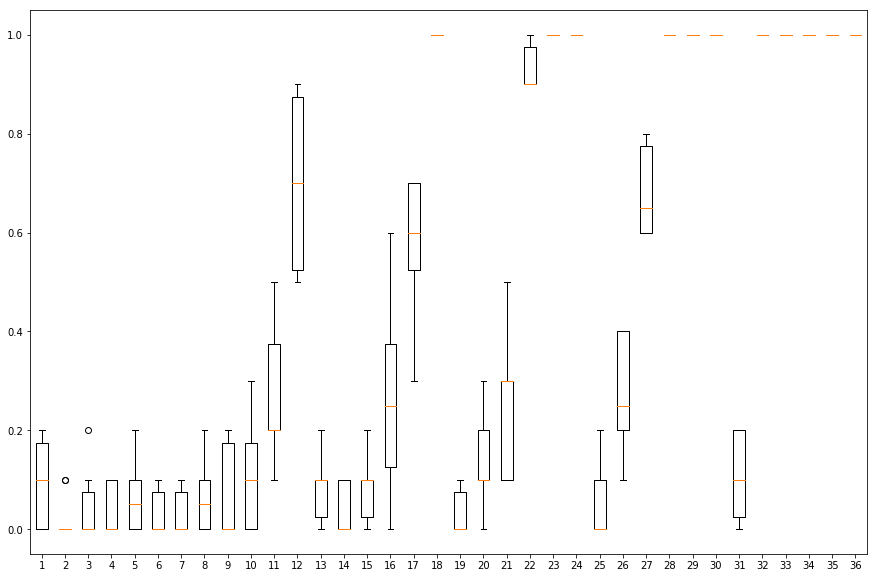

In [369]:
plt.figure(figsize=(12, 8), dpi=150)
fig, ax = plt.subplots(figsize=(15,10))
all_powers = []
for L in Ls:
    for T in Ts:
        all_powers.append(powers_meta_iter[(T, L)])
plt.boxplot(all_powers)

#     plt.boxplot(Ts, powers_L, label="Mixture, L=%s"%L, marker="o")
#     powers_L = [powers_cpma[(T, L)] for T in Ts]
#     plt.plot(Ts, powers_L, label="CPMA, L=%s"%L, marker="s")
#     powers_L = [powers_cpma_correct[(T, L)] for T in Ts]
#     plt.plot(Ts, powers_L, label="CPMA correct x, L=%s"%L, marker="^")

# plt.xlabel("# Targets (T)")
# plt.ylabel("power")
# plt.title('CPMA and Mixture Model, Power vs Ts for different Ls')
# plt.hlines(0.05, min(Ts), max(Ts), alpha=0.6)
# # ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
# plt.legend()

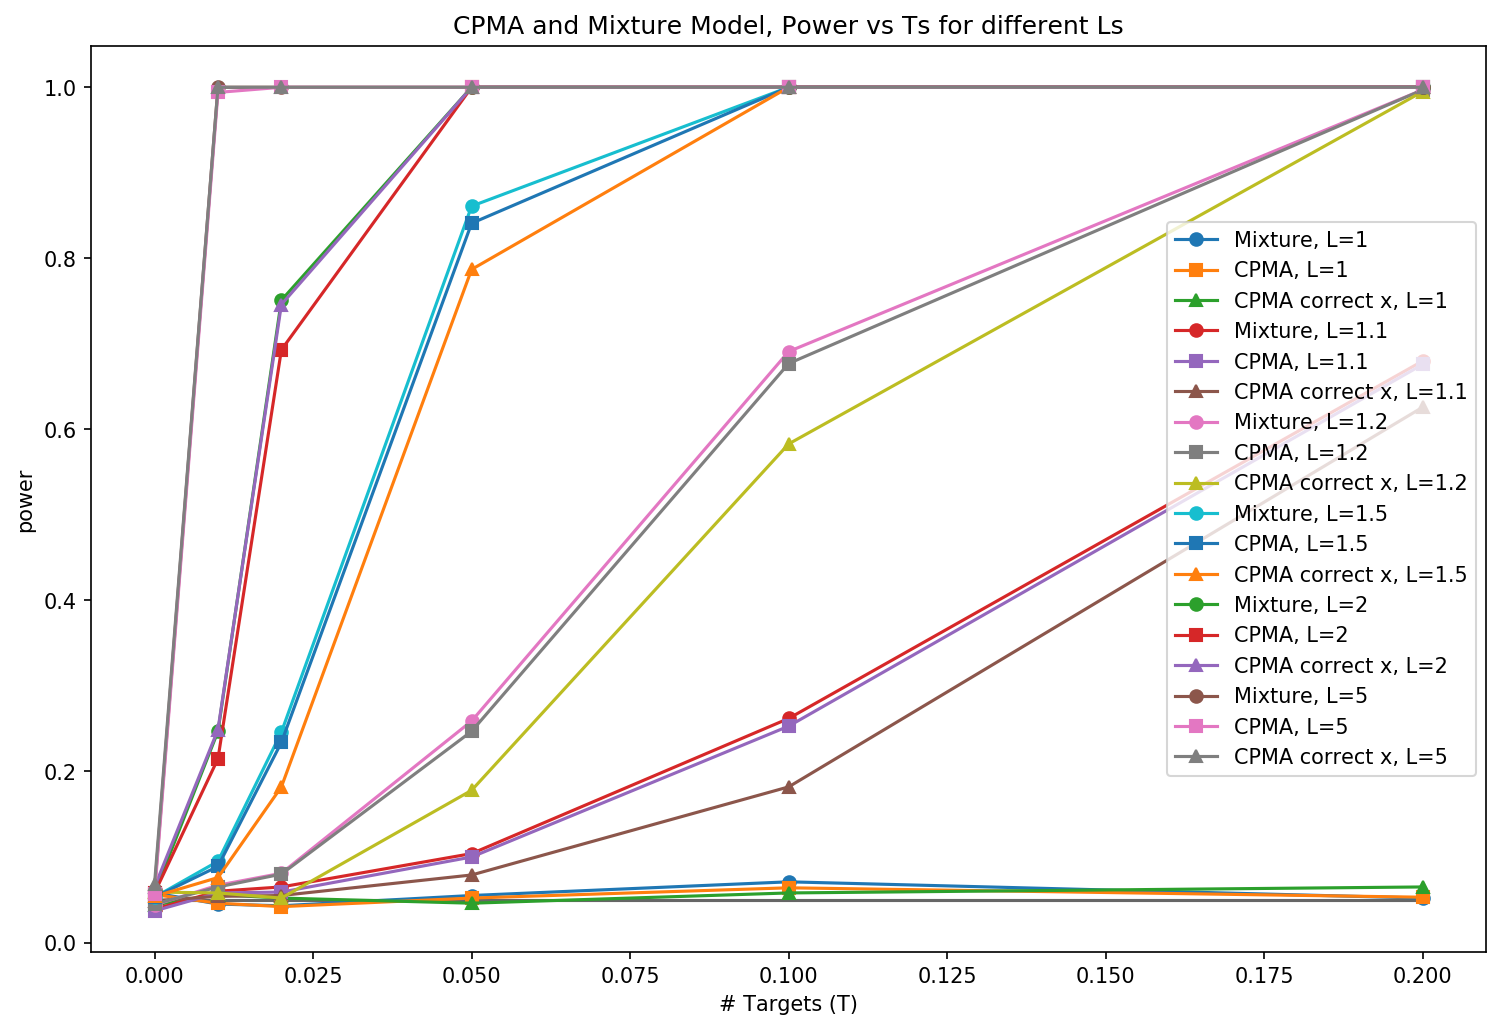

In [360]:
plt.figure(figsize=(12, 8), dpi=150)
for L in Ls:
    powers_L = [powers_meta[(T, L)] for T in Ts]
    plt.plot(Ts, powers_L, label="Mixture, L=%s"%L, marker="o")
    powers_L = [powers_cpma[(T, L)] for T in Ts]
    plt.plot(Ts, powers_L, label="CPMA, L=%s"%L, marker="s")
    powers_L = [powers_cpma_correct[(T, L)] for T in Ts]
    plt.plot(Ts, powers_L, label="CPMA correct x, L=%s"%L, marker="^")

plt.xlabel("# Targets (T)")
plt.ylabel("power")
plt.title('CPMA and Mixture Model, Power vs Ts for different Ls')
plt.hlines(0.05, min(Ts), max(Ts), alpha=0.6)
# ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
plt.legend()

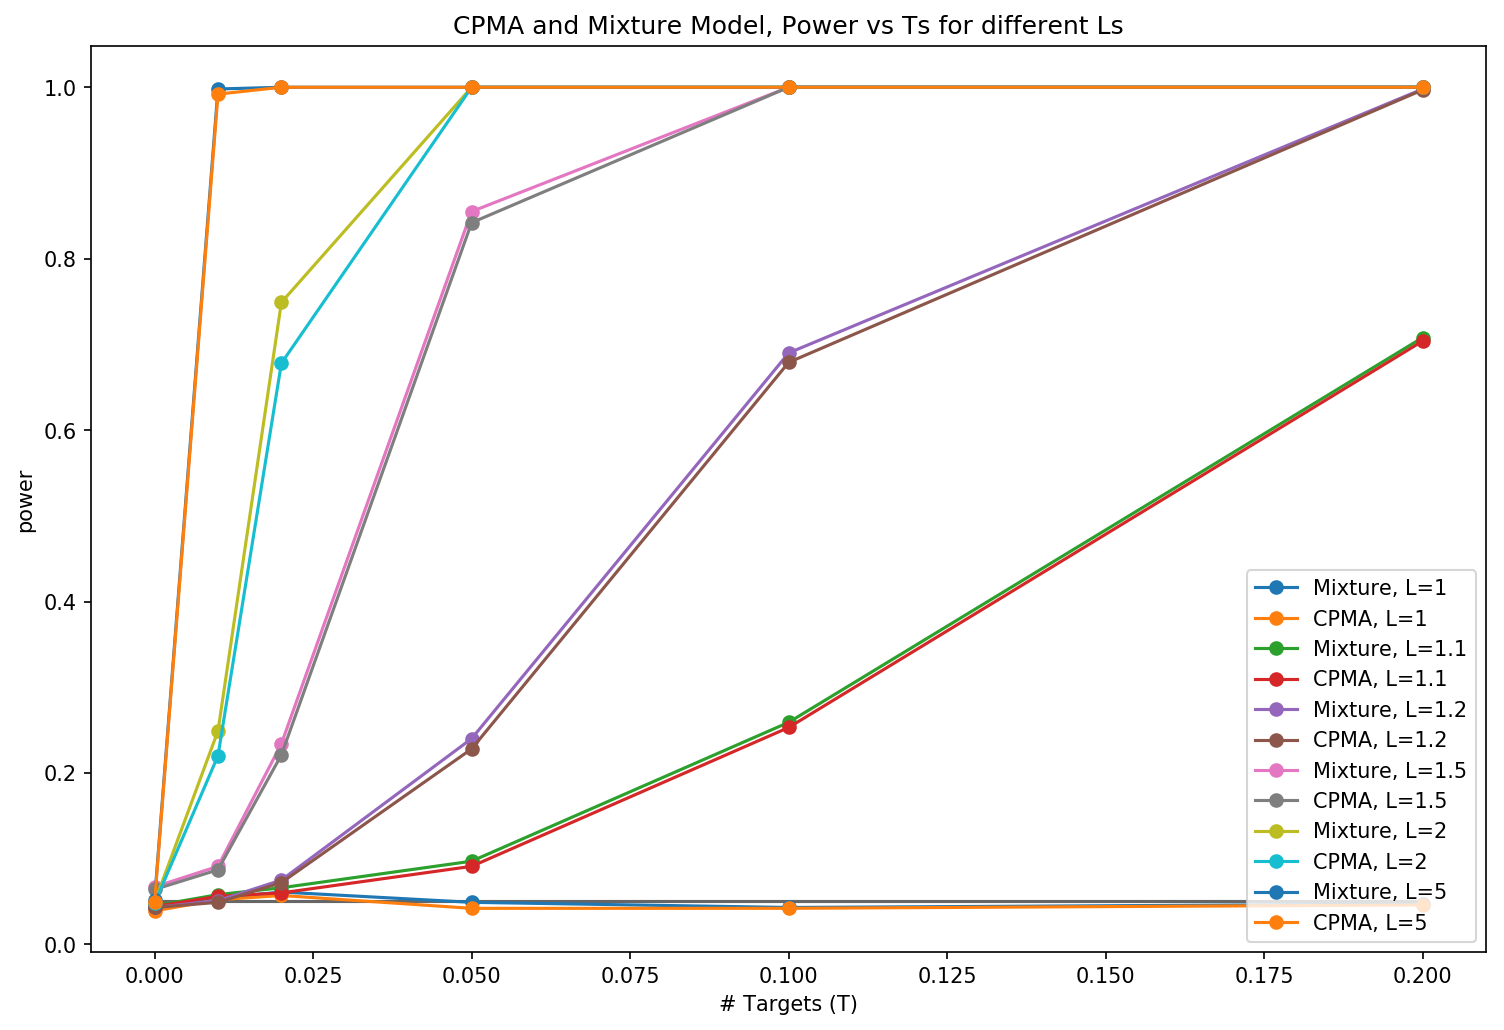

In [314]:
plt.figure(figsize=(12, 8), dpi=150)
for L in Ls:
    powers_L = [powers_meta[(T, L)] for T in Ts]
    plt.plot(Ts, powers_L, label="Mixture, L=%s"%L, marker="o")
    powers_L = [powers_cpma[(T, L)] for T in Ts]
    plt.plot(Ts, powers_L, label="CPMA, L=%s"%L, marker="o")

plt.xlabel("# Targets (T)")
plt.ylabel("power")
plt.title('CPMA and Mixture Model, Power vs Ts for different Ls')
plt.hlines(0.05, min(Ts), max(Ts), alpha=0.6)
# ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
plt.legend()

# Plots for trying out Stepwise BestT and BestT with different intial guesses

trueL=1.1; trueT=0.01; estT=0.0009440388202059138
trueL=1.1; trueT=0.05; estT=0.04281778917272925
trueL=1.1; trueT=0.1; estT=0.08186814507636542
trueL=1.1; trueT=0.25; estT=0.30789392715531994
trueL=1.5; trueT=0.01; estT=0.018339180688695087
trueL=1.5; trueT=0.05; estT=0.047547794792826246
trueL=1.5; trueT=0.1; estT=0.07994008707722479
trueL=1.5; trueT=0.25; estT=0.2602807047317803
trueL=2; trueT=0.01; estT=0.01406847832715997
trueL=2; trueT=0.05; estT=0.045659599895038795
trueL=2; trueT=0.1; estT=0.10415561031226464
trueL=2; trueT=0.25; estT=0.25949462990096844


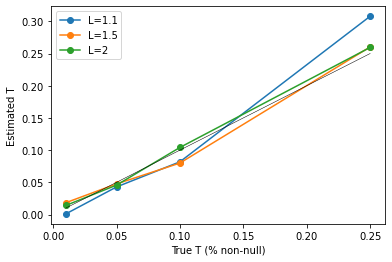

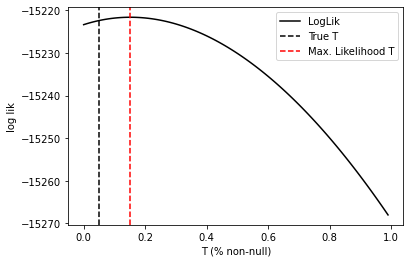

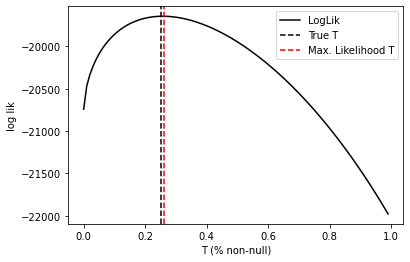

In [37]:
######################################################
# First, can we get it right if we assume we know L?
######################################################

Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestT, newlik = FindBestT(pvals, trueL)
        estTvals.append(bestT)
        title="trueL=%s; trueT=%s; estT=%s"%(trueL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()

# Plot likelihood profile of a hard case
# Likelihood surface not very pointy - 
# best guess is not that much better than other possible values for T
# probably won't have a strong p-values
T=0.05
L=1.1
pvals = SimulatePvals(G, T, L)
LikPlot(Tvals, [LogLikelihood(pvals, t, L) for t in Tvals], T, title=None)

# Plot likelihood profile of an esier case
# Likelihood surface more pointy, guess more precise
T=0.25
L=2.5
pvals = SimulatePvals(G, T, L)
LikPlot(Tvals, [LogLikelihood(pvals, t, L) for t in Tvals], T, title=None)

GuessL=2.5 GuessT=0.004480961113610198 Lik=-15299.871178249048
GuessL=2.063494861099833 GuessT=0.010089172904324685 Lik=-15299.20860397694
GuessL=1.8213729516437573 GuessT=0.016369986437068634 Lik=-15298.737591434383
GuessL=1.670094100825724 GuessT=0.02270043096231074 Lik=-15298.430481861453
GuessL=1.569436815367562 GuessT=0.02872142663718647 Lik=-15298.23400186502
GuessL=1.4977512930202883 GuessT=0.03441064840968862 Lik=-15298.103473099194
#########################
trueL=1.1; estL=1.4447555564190802; trueT=0.01; estT=0.039715814026797344
GuessL=2.5 GuessT=0.0023627536277602 Lik=-15270.601966404554
GuessL=1.9995580618180229 GuessT=0.007255081688111044 Lik=-15270.178991629205
GuessL=1.7344367471187 GuessT=0.013664821897366385 Lik=-15269.816773674173
GuessL=1.5700503840487332 GuessT=0.02105649451344323 Lik=-15269.540131388989
GuessL=1.4609820306211772 GuessT=0.028985697532632096 Lik=-15269.337227043245
GuessL=1.3845317332229672 GuessT=0.03721846934626678 Lik=-15269.187391328018
GuessL=1.

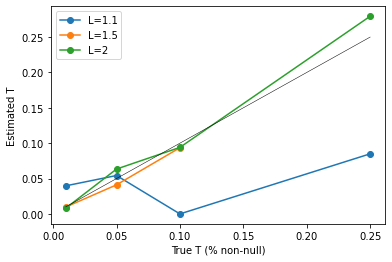

In [38]:
######################################################
# Now, can we get it right if we don't know either T or L?
######################################################


Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestL, bestT = FindBestTL(pvals)
        estTvals.append(bestT)
        print("#########################")
        title="trueL=%s; estL=%s; trueT=%s; estT=%s"%(trueL, bestL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()

GuessL=2.0 GuessT=0.006607711087543815 Lik=-15282.592538938934
GuessL=1.680516529362349 GuessT=0.015981617443364456 Lik=-15282.016023348504
GuessL=1.5079939379005871 GuessT=0.026451657138390823 Lik=-15281.604589321536
GuessL=1.4038009897828545 GuessT=0.03702285619825845 Lik=-15281.33701206688
GuessL=1.335401339334194 GuessT=0.04737096483869608 Lik=-15281.160216610993
GuessL=1.287546324362491 GuessT=0.057405151606742484 Lik=-15281.038493494658
#########################
trueL=1.1; estL=1.2521934111504225; trueT=0.01; estT=0.06715705677312095
GuessL=2.0 GuessT=0.0 Lik=-14951.425146480096
#########################
trueL=1.1; estL=1.0; trueT=0.05; estT=0.0
GuessL=2.0 GuessT=0.011835269999582267 Lik=-15371.542408864785
GuessL=1.797737873798391 GuessT=0.01843359903307483 Lik=-15371.068670663888
GuessL=1.6502813397804736 GuessT=0.026139466731802403 Lik=-15370.667077329259
GuessL=1.543478819865771 GuessT=0.03439728332543055 Lik=-15370.355204568175
GuessL=1.464462836656915 GuessT=0.0429089043142

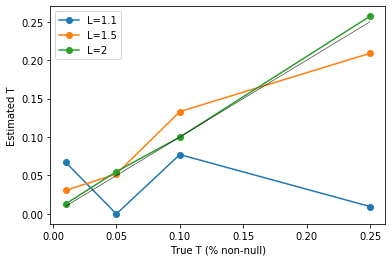

In [11]:
######################################################
# Now, can we get it right if we don't know either T or L?
######################################################


Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestL, bestT = FindBestTL(pvals)
        estTvals.append(bestT)
        print("#########################")
        title="trueL=%s; estL=%s; trueT=%s; estT=%s"%(trueL, bestL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()

GuessL=1.1 GuessT=0.0 Lik=-14933.804794761796
#########################
trueL=1.1; estL=1.0; trueT=0.01; estT=0.0
GuessL=1.1 GuessT=0.008323368301219275 Lik=-15002.461603458976
#########################
trueL=1.1; estL=1.310683691750056; trueT=0.05; estT=0.005622275472398258
GuessL=1.1 GuessT=0.15243736854850765 Lik=-15241.435134715397
#########################
trueL=1.1; estL=1.0911366617422704; trueT=0.1; estT=0.168738462004046
GuessL=1.1 GuessT=0.27216969273765385 Lik=-15391.084095443424
#########################
trueL=1.1; estL=1.1085641218058448; trueT=0.25; estT=0.2519254617835081
GuessL=1.1 GuessT=0.06822823333584713 Lik=-15101.602622491713
#########################
trueL=1.5; estL=1.1020154178392911; trueT=0.01; estT=0.06689853715431
GuessL=1.1 GuessT=0.31401859962175865 Lik=-15458.944551317396
#########################
trueL=1.5; estL=1.104184499625715; trueT=0.05; estT=0.3017331326953227
GuessL=1.1 GuessT=0.4331311567579471 Lik=-15634.696562465197
#########################
tr

GuessL=1.7293214364788032 GuessT=0.33109164561629695 Lik=-18225.472663199675
GuessL=1.788346319540397 GuessT=0.30778472631097187 Lik=-18222.19268065365
GuessL=1.8404149452497671 GuessT=0.28977232669637265 Lik=-18219.987194285623
GuessL=1.8847884715561307 GuessT=0.2759885803287755 Lik=-18218.56732717839
GuessL=1.9214997292150344 GuessT=0.2655245852407564 Lik=-18217.685216099137
GuessL=1.9511473178088234 GuessT=0.25762490081844985 Lik=-18217.152269676233
GuessL=1.9746471073288918 GuessT=0.2516802190959689 Lik=-18216.836978203573
GuessL=1.99299930172112 GuessT=0.24722198325163425 Lik=-18216.65348387316
GuessL=2.0071411084765036 GuessT=0.24389228040394476 Lik=-18216.548196081392
#########################
trueL=2; estL=2.0179453548972615; trueT=0.25; estT=0.24140396534229178


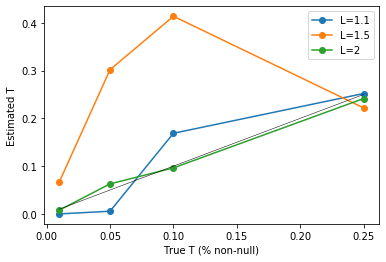

In [15]:
#Initial guess 1.1, 50 iterations

######################################################
# Now, can we get it right if we don't know either T or L?
######################################################


Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestL, bestT = FindBestTL(pvals)
        estTvals.append(bestT)
        print("#########################")
        title="trueL=%s; estL=%s; trueT=%s; estT=%s"%(trueL, bestL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()

GuessL=2.5 GuessT=0.0021633562654100316 Lik=-15064.089001890708
#########################
trueL=1.1; estL=2.405561410651201; trueT=0.01; estT=0.0024204450532559203
GuessL=2.5 GuessT=0.0013554978990200591 Lik=-15009.707303663468
#########################
trueL=1.1; estL=2.190471890932965; trueT=0.05; estT=0.002353188694059722
GuessL=2.5 GuessT=0.0017850402218951829 Lik=-15113.365833213591
#########################
trueL=1.1; estL=2.1783999864765624; trueT=0.1; estT=0.0031318173166246456
GuessL=2.5 GuessT=0.002709522497279208 Lik=-15328.94070057826
GuessL=1.9768694118070365 GuessT=0.010919025927358892 Lik=-15328.047943707024
GuessL=1.697704463048693 GuessT=0.02202995431949537 Lik=-15327.18303359596
GuessL=1.5419126686743294 GuessT=0.03304852242370797 Lik=-15326.644578426622
GuessL=1.4474393057539385 GuessT=0.04310072659887426 Lik=-15326.334685618296
GuessL=1.385227790327089 GuessT=0.052126117397510066 Lik=-15326.149711684697
GuessL=1.341944618786672 GuessT=0.06015610788587246 Lik=-15326.

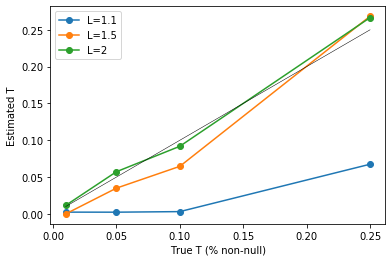

In [45]:
######################################################
# Now, can we get it right if we don't know either T or L?
######################################################


Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestL, bestT = FindBestTL(pvals)
        estTvals.append(bestT)
        print("#########################")
        title="trueL=%s; estL=%s; trueT=%s; estT=%s"%(trueL, bestL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()

GuessL=1.5 GuessT=0.0 Lik=-14986.97645341517
#########################
trueL=1.1; estL=1.0; trueT=0.01; estT=0.0
GuessL=1.5 GuessT=0.0036620263285700536 Lik=-14954.863880918028
GuessL=1.0 GuessT=0.0 Lik=-14954.900493896193
#########################
trueL=1.1; estL=1.0; trueT=0.05; estT=0.0
GuessL=1.5 GuessT=0.04399909796501277 Lik=-15269.06614540128
GuessL=1.5540602997798227 GuessT=0.03949877608254551 Lik=-15268.945361694485
GuessL=1.6019342691032865 GuessT=0.03608288167707103 Lik=-15268.8611667789
GuessL=1.6428353426506452 GuessT=0.033504750511357526 Lik=-15268.805336264622
GuessL=1.6768874120321873 GuessT=0.03155811253533291 Lik=-15268.769554624092
GuessL=1.7045463148643416 GuessT=0.030100571819843193 Lik=-15268.747265224822
GuessL=1.7268324938225368 GuessT=0.028983670322586915 Lik=-15268.733508727579
#########################
trueL=1.1; estL=1.744786414085461; trueT=0.1; estT=0.028132227721751883
GuessL=1.5 GuessT=0.06337325145752347 Lik=-15495.90287069222
GuessL=1.4743462979227415 

GuessL=2.072473709511529 GuessT=0.08873960954361562 Lik=-16277.805039723395
GuessL=2.102528772329152 GuessT=0.08607816975559285 Lik=-16277.681519445192
GuessL=2.125598562308678 GuessT=0.08412638805316303 Lik=-16277.612122997636
GuessL=2.143192641537691 GuessT=0.08268810077122835 Lik=-16277.57331815647
GuessL=2.156472359368439 GuessT=0.08162902018359877 Lik=-16277.551818884618
GuessL=2.166468857041547 GuessT=0.08084778718622264 Lik=-16277.539929922483
#########################
trueL=2; estL=2.173824754691489; trueT=0.1; estT=0.08028074570838185
GuessL=1.5 GuessT=0.47996979069388 Lik=-18305.626603029294
GuessL=1.5546266319067659 GuessT=0.43596541174783526 Lik=-18299.64126752991
GuessL=1.6096805787067099 GuessT=0.3991948924974073 Lik=-18294.66007761469
GuessL=1.663141248720406 GuessT=0.3690270588609663 Lik=-18290.741205566446
GuessL=1.7131469625178597 GuessT=0.344670655859176 Lik=-18287.81865375307
GuessL=1.7583373459559142 GuessT=0.32526697775151486 Lik=-18285.739593321305
GuessL=1.79790

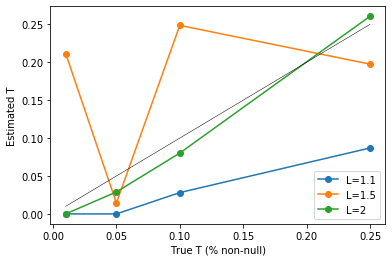

In [17]:
#Initial guess 1.5, epsilon=0.01 50 iterations

######################################################
# Now, can we get it right if we don't know either T or L?
######################################################


Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestL, bestT = FindBestTL(pvals)
        estTvals.append(bestT)
        print("#########################")
        title="trueL=%s; estL=%s; trueT=%s; estT=%s"%(trueL, bestL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()

GuessL=2.5 GuessT=0.0 Lik=-14962.112530174918
#########################
trueL=1.1; estL=1.0; trueT=0.01; estT=0.0
GuessL=2.5 GuessT=0.001081234624238105 Lik=-15126.022178599957
#########################
trueL=1.1; estL=2.10978259646616; trueT=0.05; estT=0.0025246142166637643
GuessL=2.5 GuessT=0.005540129390721937 Lik=-15314.264639508652
GuessL=2.194660281710729 GuessT=0.009093803078834754 Lik=-15313.846092180243
GuessL=1.9813886470354622 GuessT=0.013308782173049198 Lik=-15313.494805525463
GuessL=1.8292224535521007 GuessT=0.01783602910295694 Lik=-15313.225602984883
GuessL=1.7181706150247948 GuessT=0.022422513674660156 Lik=-15313.029325989162
GuessL=1.6347143283116574 GuessT=0.02688219017830847 Lik=-15312.888072449814
GuessL=1.5710668263962575 GuessT=0.03113416686987338 Lik=-15312.787213243657
#########################
trueL=1.1; estL=1.5212180778998643; trueT=0.1; estT=0.03514656026839267
GuessL=2.5 GuessT=0.010953608992373869 Lik=-15521.525901894898
GuessL=2.020702265193299 GuessT=0.02

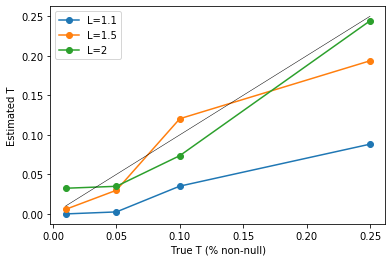

In [19]:
#Initial guess 2.5, epsilon=0.1 50 iterations

######################################################
# Now, can we get it right if we don't know either T or L?
######################################################


Tvals = np.arange(0, 1, 0.01) # Tvals to consider when searching for best
G = 15000 # number of genes

fig = plt.figure()
ax = fig.add_subplot(111)

trueTvals = [0.01, 0.05, 0.1, 0.25]
for trueL in [1.1,  1.5, 2]:
    estTvals  = []
    for trueT in trueTvals:
        pvals = SimulatePvals(G, trueT, trueL)
        bestL, bestT = FindBestTL(pvals)
        estTvals.append(bestT)
        print("#########################")
        title="trueL=%s; estL=%s; trueT=%s; estT=%s"%(trueL, bestL, trueT, bestT)
        print(title)
    ax.plot(trueTvals, estTvals, label="L=%s"%trueL, marker="o")
ax.set_xlabel("True T (% non-null)")
ax.set_ylabel("Estimated T")
ax.plot(trueTvals, trueTvals, color="black", linewidth=0.5)
ax.legend()